# CS577 Final Project: Predicting Stock Price Using RNN

Christopher W. Hong



Step 1-5 contributors: Christopher W. Hong

## The Road Ahead

* [Step 1:](#1) Preparing AAPL Data
* [Step 2:](#2) Developing a Many-to-One & One-to-One Models
* [Step 3:](#3) Optimizing the Selected Models
* [Step 4:](#4) Developing a One-to-One & One-to-Many Models
* [Step 5:](#5) Final Model

## How to Run

You could skip to **Step 5** and test the final model. Or, you could run the celss one by one to test how the final model is developed.

In [0]:
# Import necessary libraries
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,8)

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

<a id='1'></a>
## Step 1: Preparing AAPL Data

<a id='11'></a>
### Step 1.1: Loading AAPL Data

In [0]:
# Adapted from B. Overland & J. Bennett
def load_stock(ticker, start, end):
    """
    Load ticker from start date till end date into a DataFrame.
    """
    df = web.DataReader(ticker, 'yahoo', start, end)
    df = df.reset_index()
    return df

In [0]:
# Load AAPL stock data from 2010,1,1 to 2020,4,1
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2020, 4, 1)
aapl = load_stock('AAPL', start, end)

<a id='12'></a>
### Step 1.2: Exploring AAPL Data

In [0]:
print('Shape of AAPL data:', aapl.shape)

Shape of AAPL data: (2579, 7)


In [0]:
aapl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2579 non-null   datetime64[ns]
 1   High       2579 non-null   float64       
 2   Low        2579 non-null   float64       
 3   Open       2579 non-null   float64       
 4   Close      2579 non-null   float64       
 5   Volume     2579 non-null   float64       
 6   Adj Close  2579 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 141.2 KB


In [0]:
aapl.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.538483
1,2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.584366
2,2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.161509
3,2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,26.113146
4,2010-01-08,30.285715,29.865715,30.042856,30.282858,111902700.0,26.286753


In [0]:
aapl.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2579.000000,2579.000000,2579.000000,2579.000000,2.579000e+03,2579.000000
mean,115.858902,113.690446,114.766966,114.814974,7.427172e+07,108.437017
std,63.020784,61.734838,62.293667,62.431799,5.834135e+07,64.014683
min,28.000000,27.178572,27.481428,27.435715,1.136200e+07,23.815323
25%,66.021427,64.845001,65.485001,65.370716,3.111740e+07,57.658770
50%,101.540001,99.908569,100.570000,100.800003,5.477780e+07,93.212440
75%,156.689995,153.955002,155.364998,155.419998,1.009176e+08,150.392487
max,327.850006,323.350006,324.739990,327.200012,4.702495e+08,327.200012


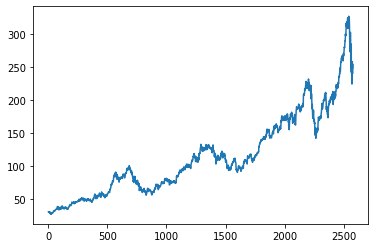

In [0]:
aapl['Close'].plot();

<a id='13'></a>
### Step 1.3: Engineering Features

In [0]:
# Drop the Date and Adj close columns
data = aapl.drop(['Date', 'Adj Close'], axis=1)
data.head()

,High,Low,Open,Close,Volume
0,30.642857,30.340000,30.490000,30.572857,123432400.0
1,30.798571,30.464285,30.657143,30.625713,150476200.0
2,30.747143,30.107143,30.625713,30.138571,138040000.0
3,30.285715,29.864286,30.250000,30.082857,119282800.0
4,30.285715,29.865715,30.042856,30.282858,111902700.0


<a id='14'></a>
### Step 1.4: Splitting the Data into train, valid and test set

In [0]:
def split_data(data, train_idx, valid_idx=None, test=False):
  """
  Split the data into train, test and/or valida set.
  """
  data = data.values
  if test:
    train_data = data[:train_idx, :]
    test_data = data[train_idx:, :]
    return train_data, test_data
  else:
    train_data = data[:train_idx, :]
    valid_data = data[train_idx:valid_idx, :]
    test_data = data[valid_idx:, :]
    return train_data, valid_data, test_data

In [0]:
# train data are approximately two and half years agao 
# valida data is about second recent 1 and half years 
# test data is about first recent 1 and half years till the end
train_data, valid_data, test_data = split_data(data, 2000, 2289)

<a id='15'></a>
### Step 1.5: Normalizing the Data

In [0]:
def normalize_data(train_data, valid_data=None, test_data=None, test=False):
  """
  MinMax normalize the train, test and/or valida set.
  """
  scaler = MinMaxScaler()
  train_data = scaler.fit_transform(train_data)

  if test:
    test_data =  scaler.transform(test_data)
    return scaler, train_data, test_data
  else:
    valid_data = scaler.transform(valid_data)
    test_data = scaler.transform(test_data)
    return scaler, train_data, valid_data, test_data

In [0]:
scaler, train_data, valid_data, test_data = normalize_data(train_data, valid_data, test_data)

<a id='16'></a>
### Step 1.6: Generating Timeseries Samples and their Targets

In [0]:
# Adapted from J. Brownlee
def split_sequence_mto(data, n_steps):
  """
  Split a sequence into many to one or one to one depending on the time setps.
  """
  X, Y = [], []
  for i in np.arange(len(data)):
    end_idx = i + n_steps
    # Check if the idx is out of bound
    if end_idx > len(data) - 1:
      break
    x, y = data[i:end_idx, :], data[end_idx, 3]
    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)

In [0]:
# Use the previous 4 days to predict the 5th days's price
n_steps, n_features = 4, 5
X_train, y_train = split_sequence_mto(train_data, n_steps)
X_valid, y_valid = split_sequence_mto(valid_data, n_steps)
X_test, y_test = split_sequence_mto(test_data, n_steps)

print('X_train shape:', X_train.shape)
print('y_train :', len(y_train))
print('X_valid shape:', X_valid.shape)
print('y_valid :', len(y_valid))
print('X_test shape:', X_test.shape)
print('y_test :', len(y_test))

X_train shape: (1996, 4, 5)
y_train : 1996
X_valid shape: (285, 4, 5)
y_valid : 285
X_test shape: (286, 4, 5)
y_test : 286


<a id='2'></a>
## Step 2: Developing a model

<a id='21'></a>
### Step 2.1: A Common-sense, Non-machine-learning Baseline

In [0]:
# Adapted from F. Chollet
# Always predict tomorrow's price using today's price
preds_y_valid = X_valid[:, 3, 3]
print('Normalized base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)))
print('Original base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)) * scaler.data_range_[3])

preds_y_test = X_test[:, 3, 3]
print('Normalized base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)))
print('Original base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)) * scaler.data_range_[3])

Normalized base line MAE on validation data: 0.01649334527045131
Original base line MAE on validation data: 2.4542805454187233
Normalized base line MAE on test data: 0.02410966908567308
Original base line MAE on test data: 3.5876222090287646


<a id='22'></a>
### Step 2.2: A FC Model

In [0]:
def eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test):
  """
  Print MAE on train, valid and test set.
  """
  preds_y_valid = X_valid[:, n_steps-1, 3]
  print('\nNormalized base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)))
  print('Original base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)) * scaler.data_range_[3])

  preds_y_test = X_test[:, n_steps-1, 3]
  print('Normalized base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)))
  print('Original base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)) * scaler.data_range_[3])

  print('Validation MAE:', model.evaluate(X_valid, y_valid)[1])
  print('Original validation MAE:', model.evaluate(X_valid, y_valid)[1] * scaler.data_range_[3])
  print('Test MAE:', model.evaluate(X_test, y_test)[1])
  print('Original test MAE:', model.evaluate(X_test, y_test)[1] * scaler.data_range_[3])

In [0]:
def plot_model(history, model, X_test, y_test):
  """
  Plot MAE, loss and predicted close price on test set.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = np.arange(1, len(loss) + 1)

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training mae')
  plt.plot(epochs, val_loss, 'b', label='Validation mae')
  plt.title('Training and validation mae')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  
  plt.figure()

  plt.plot(y_test, 'b', label='Actual')
  plt.plot(model.predict(X_test), 'r', label='Predictedt')
  plt.title('Actual vs. predicted close price on test set')
  plt.legend()
  plt.show();

Train on 1996 samples, validate on 285 samples
Epoch 1/200
1996/1996 [==============================] - 0s 142us/step - loss: 0.2447 - mae: 0.2447 - val_loss: 0.1568 - val_mae: 0.1568
Epoch 2/200
1996/1996 [==============================] - 0s 99us/step - loss: 0.2206 - mae: 0.2206 - val_loss: 0.0981 - val_mae: 0.0981
Epoch 3/200
1996/1996 [==============================] - 0s 98us/step - loss: 0.2019 - mae: 0.2019 - val_loss: 0.1062 - val_mae: 0.1062
Epoch 4/200
1996/1996 [==============================] - 0s 85us/step - loss: 0.1770 - mae: 0.1770 - val_loss: 0.0699 - val_mae: 0.0699
Epoch 5/200
1996/1996 [==============================] - 0s 88us/step - loss: 0.1619 - mae: 0.1619 - val_loss: 0.0734 - val_mae: 0.0734
Epoch 6/200
1996/1996 [==============================] - 0s 84us/step - loss: 0.1545 - mae: 0.1545 - val_loss: 0.0704 - val_mae: 0.0704
Epoch 7/200
1996/1996 [==============================] - 0s 88us/step - loss: 0.1357 - mae: 0.1357 - val_loss: 0.0995 - val_mae: 0.0995


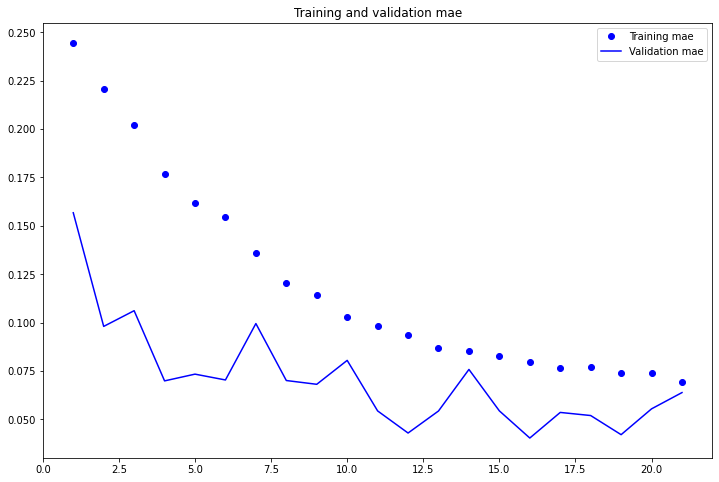

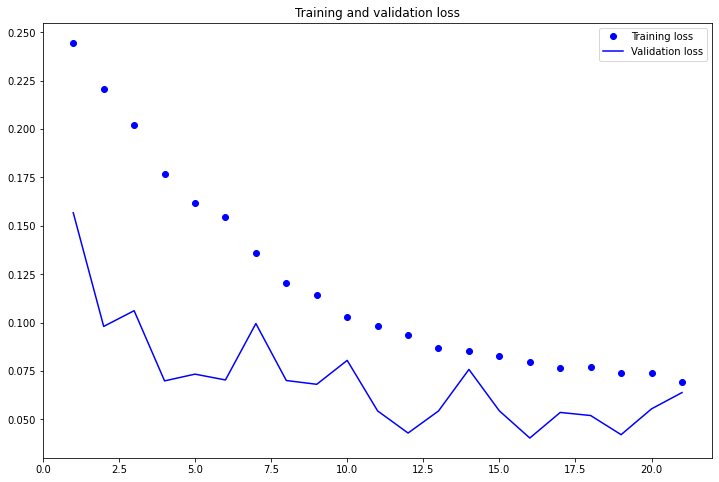

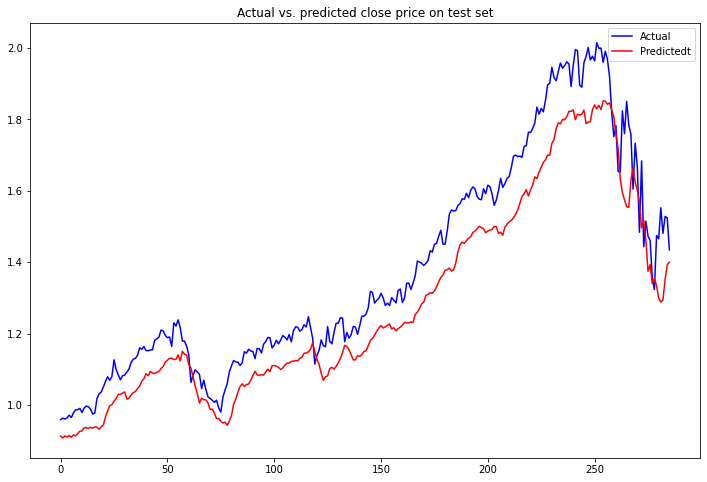

In [0]:
# MLP model
model = Sequential()
model.add(layers.Flatten(input_shape=(n_steps, n_features)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='23'></a>
### Step 2.3: A GRU Model

Train on 1996 samples, validate on 285 samples
Epoch 1/200
1996/1996 [==============================] - 1s 629us/step - loss: 0.3657 - mae: 0.3657 - val_loss: 0.7365 - val_mae: 0.7365
Epoch 2/200
1996/1996 [==============================] - 1s 411us/step - loss: 0.1094 - mae: 0.1094 - val_loss: 0.3957 - val_mae: 0.3957
Epoch 3/200
1996/1996 [==============================] - 1s 412us/step - loss: 0.0751 - mae: 0.0751 - val_loss: 0.3602 - val_mae: 0.3602
Epoch 4/200
1996/1996 [==============================] - 1s 429us/step - loss: 0.0588 - mae: 0.0588 - val_loss: 0.3108 - val_mae: 0.3108
Epoch 5/200
1996/1996 [==============================] - 1s 422us/step - loss: 0.0554 - mae: 0.0554 - val_loss: 0.2923 - val_mae: 0.2923
Epoch 6/200
1996/1996 [==============================] - 1s 438us/step - loss: 0.0534 - mae: 0.0534 - val_loss: 0.2922 - val_mae: 0.2922
Epoch 7/200
1996/1996 [==============================] - 1s 407us/step - loss: 0.0499 - mae: 0.0499 - val_loss: 0.2664 - val_mae: 0

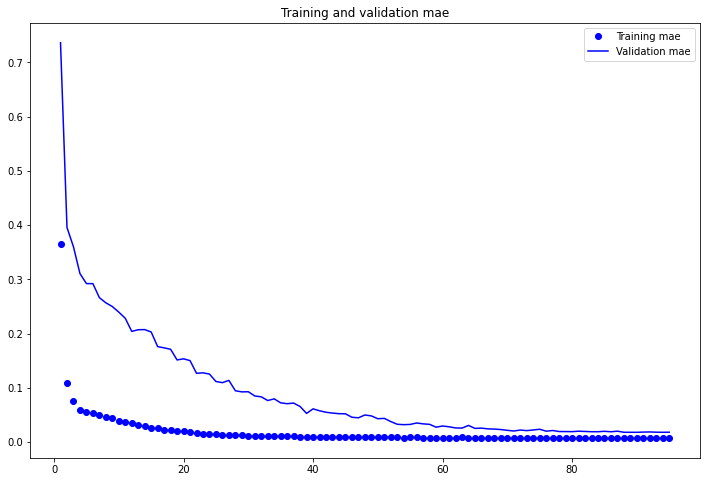

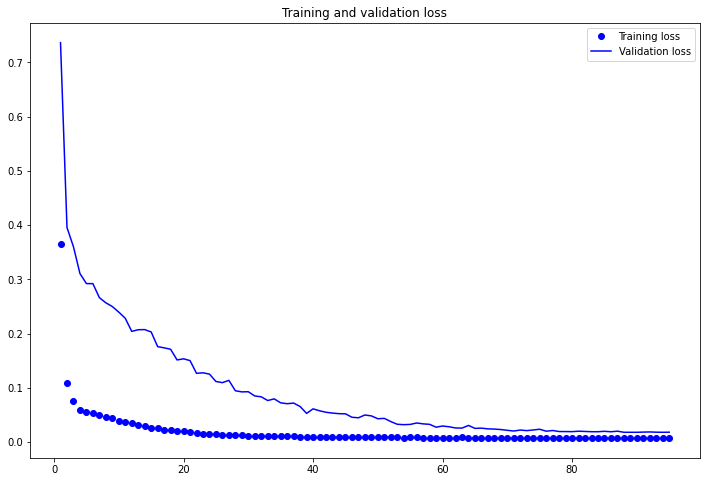

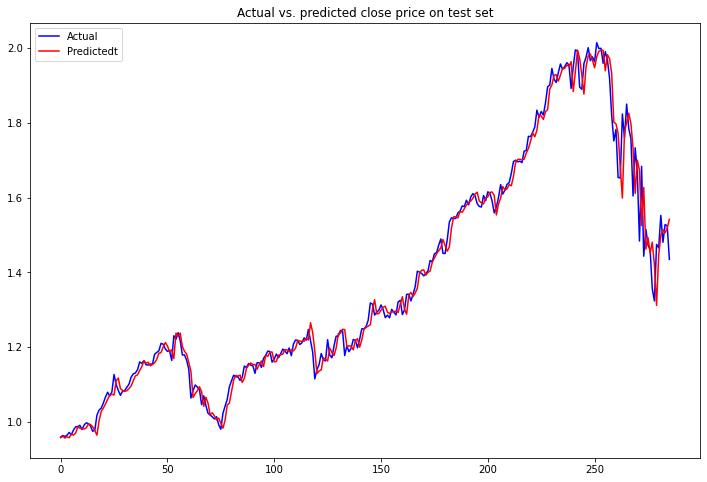

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='24'></a>
### Step 2.4: A LSTM Model

Train on 1996 samples, validate on 285 samples
Epoch 1/200
1996/1996 [==============================] - 1s 520us/step - loss: 0.2760 - mae: 0.2760 - val_loss: 0.5654 - val_mae: 0.5654
Epoch 2/200
1996/1996 [==============================] - 1s 337us/step - loss: 0.1104 - mae: 0.1104 - val_loss: 0.1241 - val_mae: 0.1241
Epoch 3/200
1996/1996 [==============================] - 1s 350us/step - loss: 0.0517 - mae: 0.0517 - val_loss: 0.0521 - val_mae: 0.0521
Epoch 4/200
1996/1996 [==============================] - 1s 340us/step - loss: 0.0351 - mae: 0.0351 - val_loss: 0.0255 - val_mae: 0.0255
Epoch 5/200
1996/1996 [==============================] - 1s 344us/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0338 - val_mae: 0.0338
Epoch 6/200
1996/1996 [==============================] - 1s 352us/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0312 - val_mae: 0.0312
Epoch 7/200
1996/1996 [==============================] - 1s 341us/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0277 - val_mae: 0

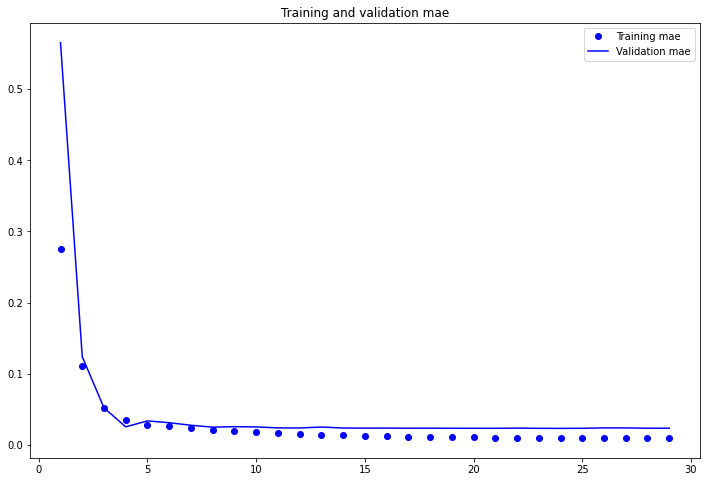

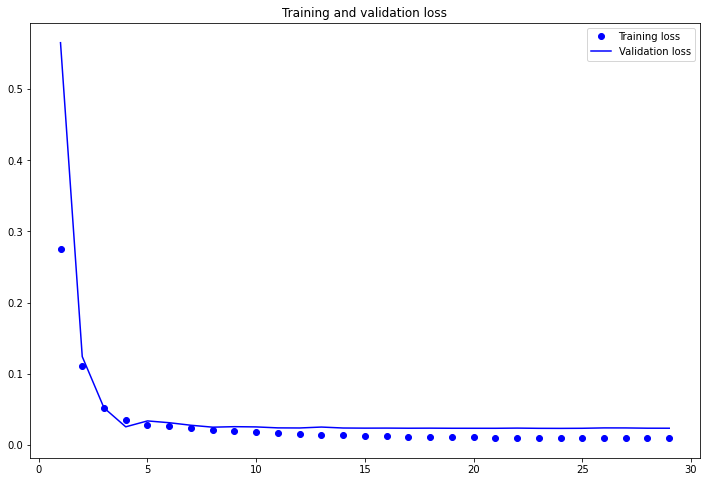

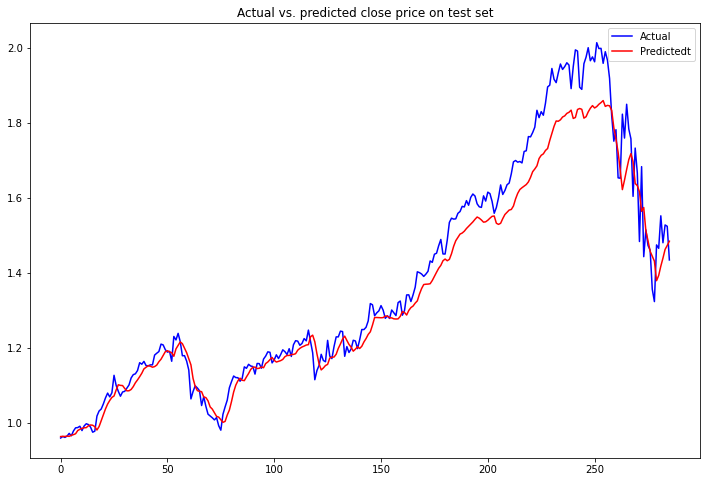

In [0]:
# LSTM model
model = Sequential()
model.add(layers.LSTM(64, recurrent_dropout=0.5, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='3'></a>
## Step 3: Optimizing the Model

<a id='31'></a>
### Step 3.1: Using Ten Days Lags

In [0]:
# Use the previous 10 days to predict the 11th day's price
n_steps = 10
X_train, y_train = split_sequence_mto(train_data, n_steps)
X_valid, y_valid = split_sequence_mto(valid_data, n_steps)
X_test, y_test = split_sequence_mto(test_data, n_steps)

Train on 1990 samples, validate on 279 samples
Epoch 1/200
1990/1990 [==============================] - 0s 140us/step - loss: 0.3481 - mae: 0.3481 - val_loss: 0.2028 - val_mae: 0.2028
Epoch 2/200
1990/1990 [==============================] - 0s 90us/step - loss: 0.2601 - mae: 0.2601 - val_loss: 0.0800 - val_mae: 0.0800
Epoch 3/200
1990/1990 [==============================] - 0s 85us/step - loss: 0.2259 - mae: 0.2259 - val_loss: 0.0609 - val_mae: 0.0609
Epoch 4/200
1990/1990 [==============================] - 0s 82us/step - loss: 0.1920 - mae: 0.1920 - val_loss: 0.0709 - val_mae: 0.0709
Epoch 5/200
1990/1990 [==============================] - 0s 92us/step - loss: 0.1633 - mae: 0.1633 - val_loss: 0.0580 - val_mae: 0.0580
Epoch 6/200
1990/1990 [==============================] - 0s 85us/step - loss: 0.1429 - mae: 0.1429 - val_loss: 0.0889 - val_mae: 0.0889
Epoch 7/200
1990/1990 [==============================] - 0s 88us/step - loss: 0.1180 - mae: 0.1180 - val_loss: 0.0567 - val_mae: 0.0567


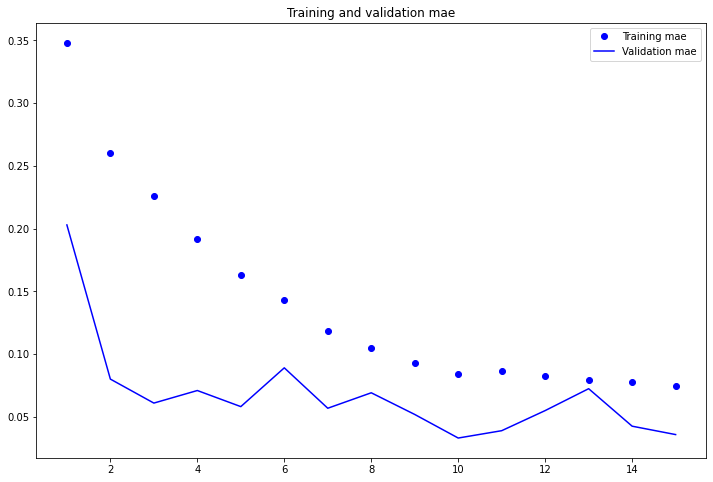

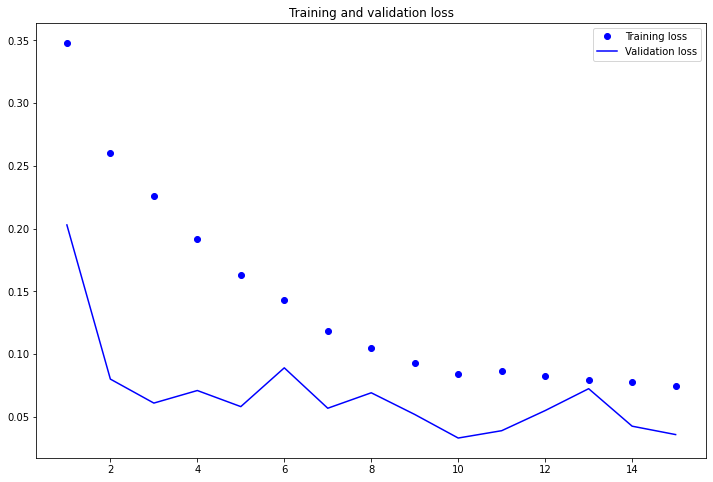

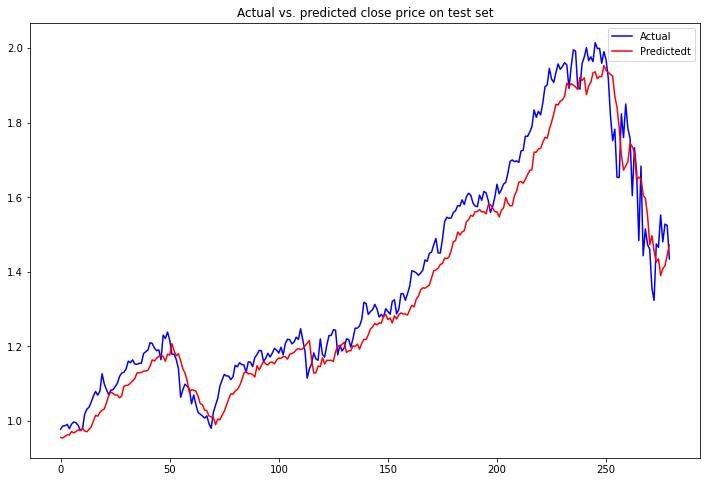

In [0]:
# MLP model
model = Sequential()
model.add(layers.Flatten(input_shape=(n_steps, n_features)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 1990 samples, validate on 279 samples
Epoch 1/200
1990/1990 [==============================] - 2s 1ms/step - loss: 0.1495 - mae: 0.1495 - val_loss: 0.7665 - val_mae: 0.7665
Epoch 2/200
1990/1990 [==============================] - 2s 838us/step - loss: 0.1082 - mae: 0.1082 - val_loss: 0.6915 - val_mae: 0.6915
Epoch 3/200
1990/1990 [==============================] - 2s 858us/step - loss: 0.0842 - mae: 0.0842 - val_loss: 0.6353 - val_mae: 0.6353
Epoch 4/200
1990/1990 [==============================] - 2s 872us/step - loss: 0.0685 - mae: 0.0685 - val_loss: 0.5912 - val_mae: 0.5912
Epoch 5/200
1990/1990 [==============================] - 2s 829us/step - loss: 0.0569 - mae: 0.0569 - val_loss: 0.5509 - val_mae: 0.5509
Epoch 6/200
1990/1990 [==============================] - 2s 849us/step - loss: 0.0508 - mae: 0.0508 - val_loss: 0.5227 - val_mae: 0.5227
Epoch 7/200
1990/1990 [==============================] - 2s 876us/step - loss: 0.0455 - mae: 0.0455 - val_loss: 0.5000 - val_mae: 0.5

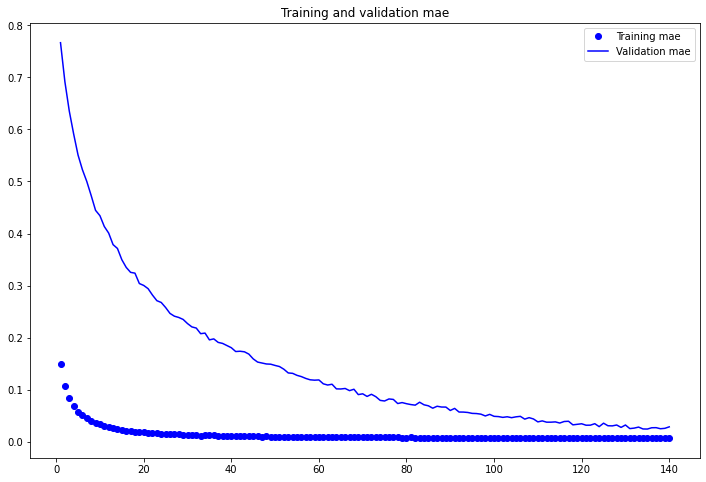

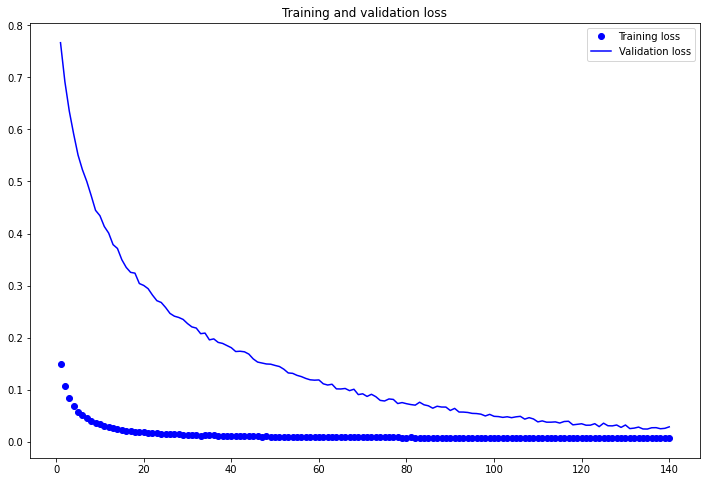

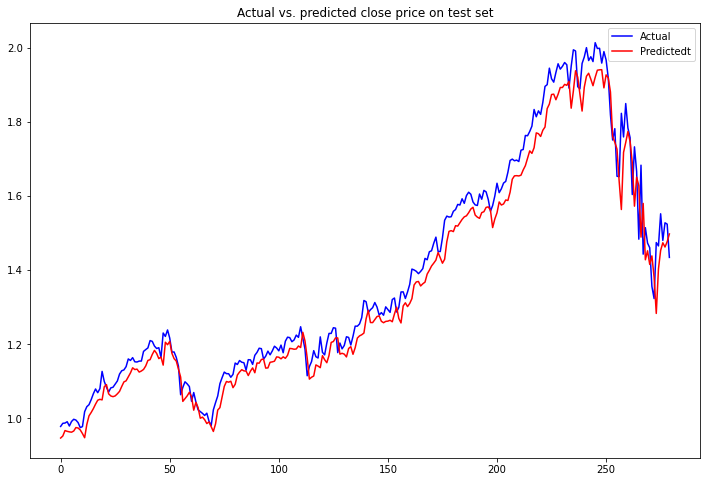

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 1990 samples, validate on 279 samples
Epoch 1/200
1990/1990 [==============================] - 2s 865us/step - loss: 0.2774 - mae: 0.2774 - val_loss: 0.3099 - val_mae: 0.3099
Epoch 2/200
1990/1990 [==============================] - 1s 682us/step - loss: 0.0670 - mae: 0.0670 - val_loss: 0.1040 - val_mae: 0.1040
Epoch 3/200
1990/1990 [==============================] - 1s 677us/step - loss: 0.0474 - mae: 0.0474 - val_loss: 0.0592 - val_mae: 0.0592
Epoch 4/200
1990/1990 [==============================] - 1s 669us/step - loss: 0.0403 - mae: 0.0403 - val_loss: 0.0537 - val_mae: 0.0537
Epoch 5/200
1990/1990 [==============================] - 1s 666us/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.0445 - val_mae: 0.0445
Epoch 6/200
1990/1990 [==============================] - 1s 715us/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 7/200
1990/1990 [==============================] - 1s 678us/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0319 - val_mae: 0

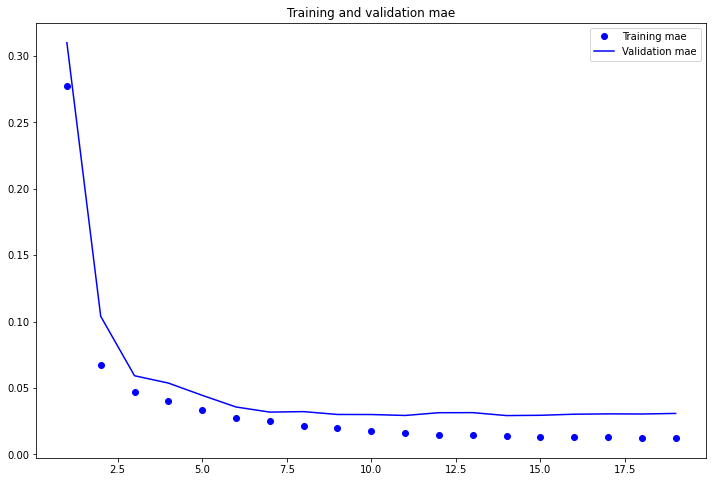

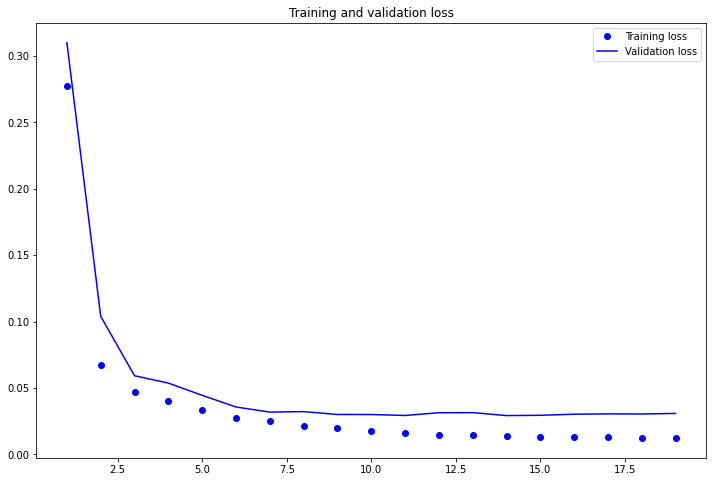

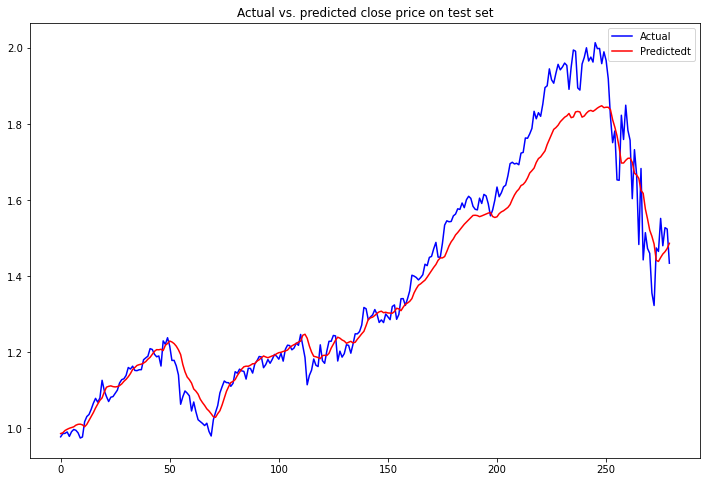

In [0]:
# LSTM model
model = Sequential()
model.add(layers.LSTM(64, recurrent_dropout=0.5, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='32'></a>
### Step 3.2: Using One Day Lag

In [0]:
# Use the previous 1 days to predict the 2nd day's price
n_steps = 1
X_train, y_train = split_sequence_mto(train_data, n_steps)
X_valid, y_valid = split_sequence_mto(valid_data, n_steps)
X_test, y_test = split_sequence_mto(test_data, n_steps)

Train on 1999 samples, validate on 288 samples
Epoch 1/200
1999/1999 [==============================] - 0s 143us/step - loss: 0.3435 - mae: 0.3435 - val_loss: 0.7639 - val_mae: 0.7639
Epoch 2/200
1999/1999 [==============================] - 0s 95us/step - loss: 0.2476 - mae: 0.2476 - val_loss: 0.5785 - val_mae: 0.5785
Epoch 3/200
1999/1999 [==============================] - 0s 86us/step - loss: 0.1879 - mae: 0.1879 - val_loss: 0.4323 - val_mae: 0.4323
Epoch 4/200
1999/1999 [==============================] - 0s 84us/step - loss: 0.1593 - mae: 0.1593 - val_loss: 0.3410 - val_mae: 0.3410
Epoch 5/200
1999/1999 [==============================] - 0s 86us/step - loss: 0.1545 - mae: 0.1545 - val_loss: 0.2817 - val_mae: 0.2817
Epoch 6/200
1999/1999 [==============================] - 0s 80us/step - loss: 0.1436 - mae: 0.1436 - val_loss: 0.2539 - val_mae: 0.2539
Epoch 7/200
1999/1999 [==============================] - 0s 77us/step - loss: 0.1328 - mae: 0.1328 - val_loss: 0.2296 - val_mae: 0.2296


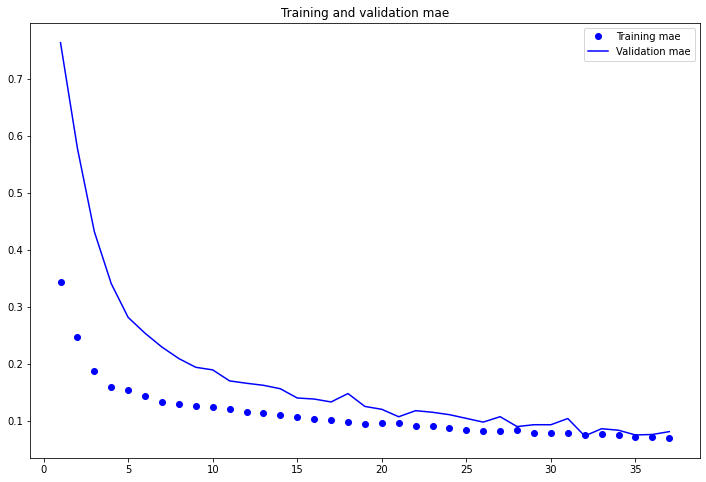

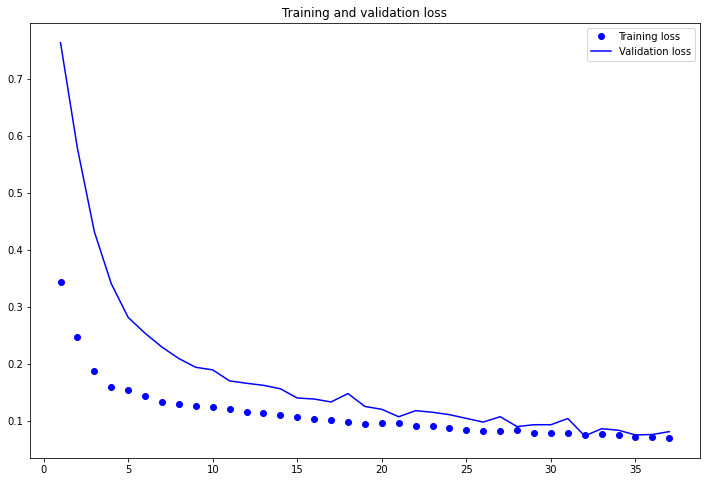

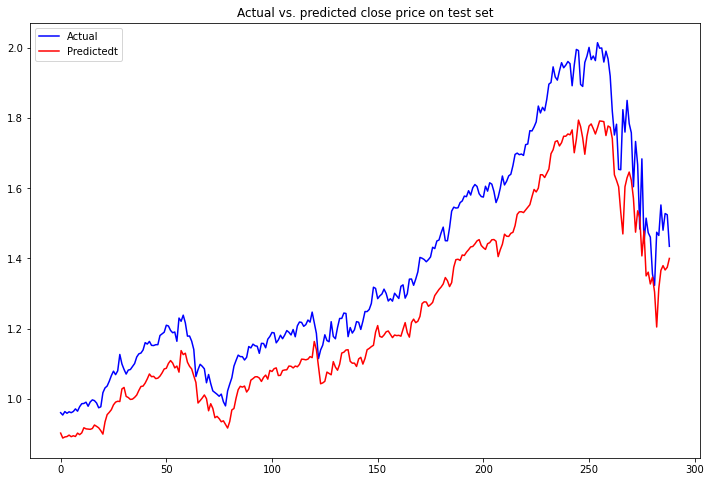

In [0]:
# MLP model
model = Sequential()
model.add(layers.Flatten(input_shape=(n_steps, n_features)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 1999 samples, validate on 288 samples
Epoch 1/200
1999/1999 [==============================] - 1s 390us/step - loss: 0.4014 - mae: 0.4014 - val_loss: 1.0333 - val_mae: 1.0333
Epoch 2/200
1999/1999 [==============================] - 0s 217us/step - loss: 0.3120 - mae: 0.3120 - val_loss: 0.8376 - val_mae: 0.8376
Epoch 3/200
1999/1999 [==============================] - 0s 205us/step - loss: 0.2294 - mae: 0.2294 - val_loss: 0.6414 - val_mae: 0.6414
Epoch 4/200
1999/1999 [==============================] - 0s 200us/step - loss: 0.1624 - mae: 0.1624 - val_loss: 0.4541 - val_mae: 0.4541
Epoch 5/200
1999/1999 [==============================] - 0s 203us/step - loss: 0.1159 - mae: 0.1159 - val_loss: 0.3039 - val_mae: 0.3039
Epoch 6/200
1999/1999 [==============================] - 0s 202us/step - loss: 0.0884 - mae: 0.0884 - val_loss: 0.1970 - val_mae: 0.1970
Epoch 7/200
1999/1999 [==============================] - 0s 241us/step - loss: 0.0690 - mae: 0.0690 - val_loss: 0.1298 - val_mae: 0

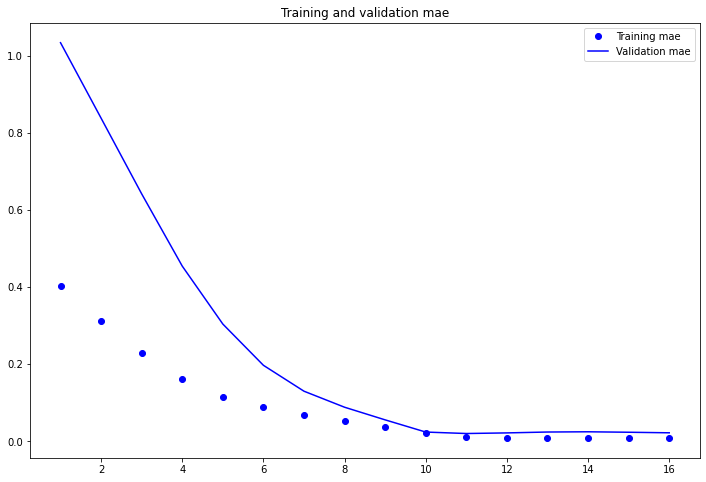

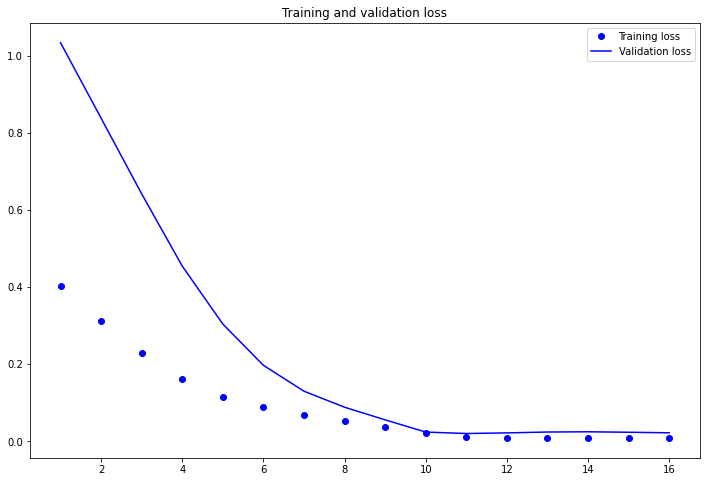

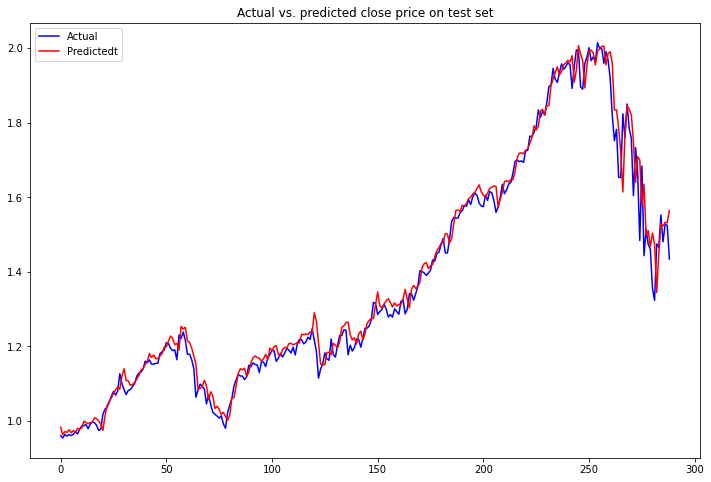

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 1999 samples, validate on 288 samples
Epoch 1/200
1999/1999 [==============================] - 1s 357us/step - loss: 0.3841 - mae: 0.3841 - val_loss: 0.9721 - val_mae: 0.9721
Epoch 2/200
1999/1999 [==============================] - 0s 171us/step - loss: 0.3232 - mae: 0.3232 - val_loss: 0.8489 - val_mae: 0.8489
Epoch 3/200
1999/1999 [==============================] - 0s 174us/step - loss: 0.2645 - mae: 0.2645 - val_loss: 0.7188 - val_mae: 0.7188
Epoch 4/200
1999/1999 [==============================] - 0s 192us/step - loss: 0.2054 - mae: 0.2054 - val_loss: 0.5777 - val_mae: 0.5777
Epoch 5/200
1999/1999 [==============================] - 0s 173us/step - loss: 0.1518 - mae: 0.1518 - val_loss: 0.4342 - val_mae: 0.4342
Epoch 6/200
1999/1999 [==============================] - 0s 185us/step - loss: 0.1081 - mae: 0.1081 - val_loss: 0.2931 - val_mae: 0.2931
Epoch 7/200
1999/1999 [==============================] - 0s 180us/step - loss: 0.0790 - mae: 0.0790 - val_loss: 0.1836 - val_mae: 0

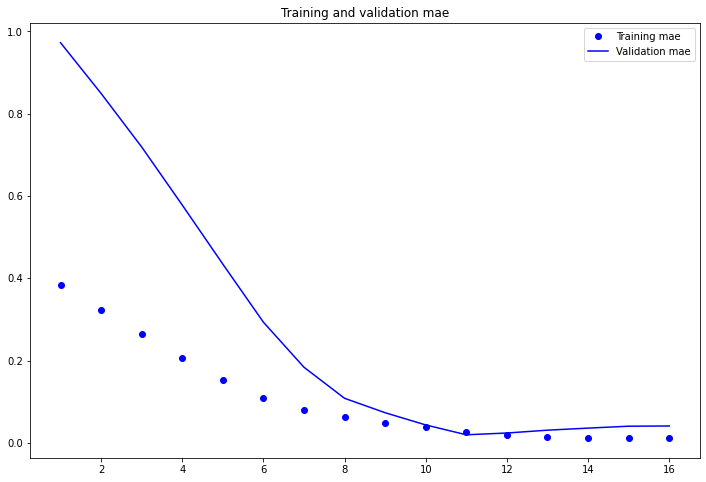

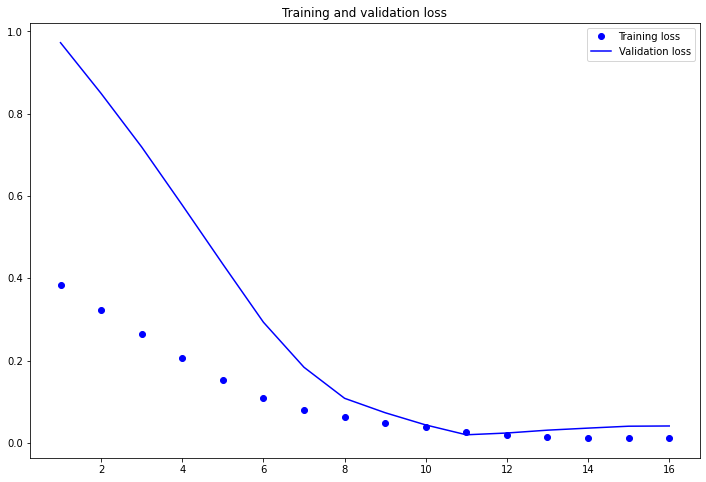

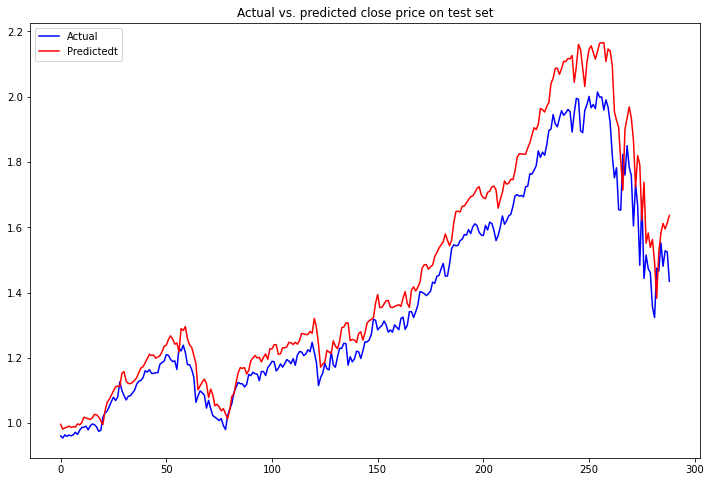

In [0]:
# LSTM model
model = Sequential()
model.add(layers.LSTM(64, recurrent_dropout=0.5, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='33'></a>
### Step 3.3: Using Twnety Days Lags

In [0]:
# Use the previous 20 days to predict the 21th day's price
n_steps = 20
X_train, y_train = split_sequence_mto(train_data, n_steps)
X_valid, y_valid = split_sequence_mto(valid_data, n_steps)
X_test, y_test = split_sequence_mto(test_data, n_steps)

Train on 1980 samples, validate on 269 samples
Epoch 1/200
1980/1980 [==============================] - 0s 139us/step - loss: 0.3090 - mae: 0.3090 - val_loss: 0.0803 - val_mae: 0.0803
Epoch 2/200
1980/1980 [==============================] - 0s 93us/step - loss: 0.2453 - mae: 0.2453 - val_loss: 0.1107 - val_mae: 0.1107
Epoch 3/200
1980/1980 [==============================] - 0s 83us/step - loss: 0.1899 - mae: 0.1899 - val_loss: 0.1193 - val_mae: 0.1193
Epoch 4/200
1980/1980 [==============================] - 0s 88us/step - loss: 0.1418 - mae: 0.1418 - val_loss: 0.0866 - val_mae: 0.0866
Epoch 5/200
1980/1980 [==============================] - 0s 91us/step - loss: 0.1169 - mae: 0.1169 - val_loss: 0.0584 - val_mae: 0.0584
Epoch 6/200
1980/1980 [==============================] - 0s 87us/step - loss: 0.0992 - mae: 0.0992 - val_loss: 0.0642 - val_mae: 0.0642
Epoch 7/200
1980/1980 [==============================] - 0s 94us/step - loss: 0.0929 - mae: 0.0929 - val_loss: 0.0909 - val_mae: 0.0909


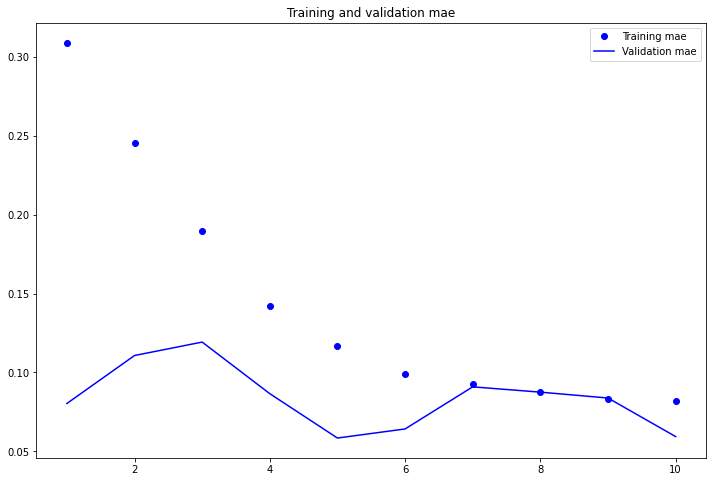

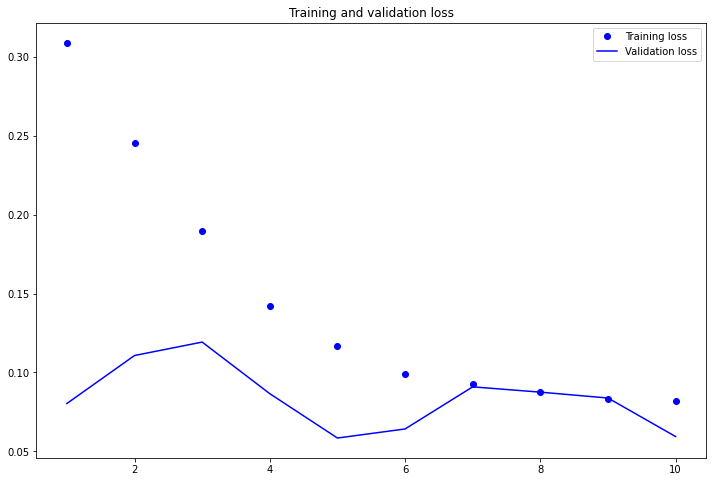

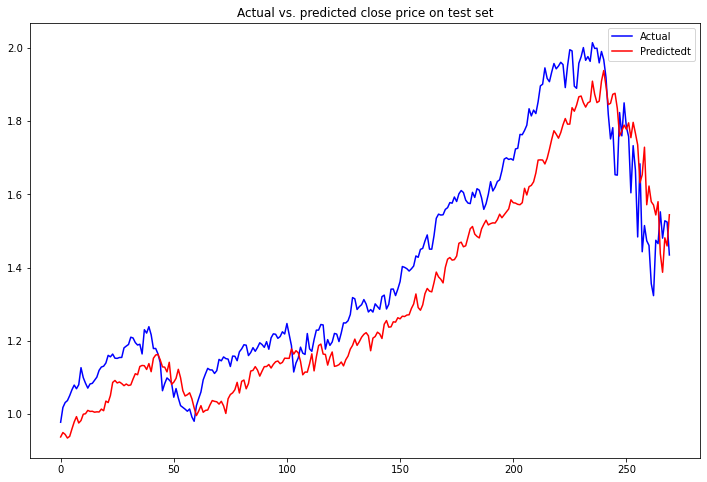

In [0]:
# MLP model
model = Sequential()
model.add(layers.Flatten(input_shape=(n_steps, n_features)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 1980 samples, validate on 269 samples
Epoch 1/200
1980/1980 [==============================] - 3s 2ms/step - loss: 0.9594 - mae: 0.9594 - val_loss: 0.4413 - val_mae: 0.4413
Epoch 2/200
1980/1980 [==============================] - 3s 2ms/step - loss: 0.4068 - mae: 0.4068 - val_loss: 0.4289 - val_mae: 0.4289
Epoch 3/200
1980/1980 [==============================] - 3s 1ms/step - loss: 0.2823 - mae: 0.2823 - val_loss: 0.4240 - val_mae: 0.4240
Epoch 4/200
1980/1980 [==============================] - 3s 2ms/step - loss: 0.2140 - mae: 0.2140 - val_loss: 0.4201 - val_mae: 0.4201
Epoch 5/200
1980/1980 [==============================] - 3s 1ms/step - loss: 0.1667 - mae: 0.1667 - val_loss: 0.4071 - val_mae: 0.4071
Epoch 6/200
1980/1980 [==============================] - 3s 1ms/step - loss: 0.1421 - mae: 0.1421 - val_loss: 0.4058 - val_mae: 0.4058
Epoch 7/200
1980/1980 [==============================] - 3s 1ms/step - loss: 0.1222 - mae: 0.1222 - val_loss: 0.3993 - val_mae: 0.3993
Epoch 8/

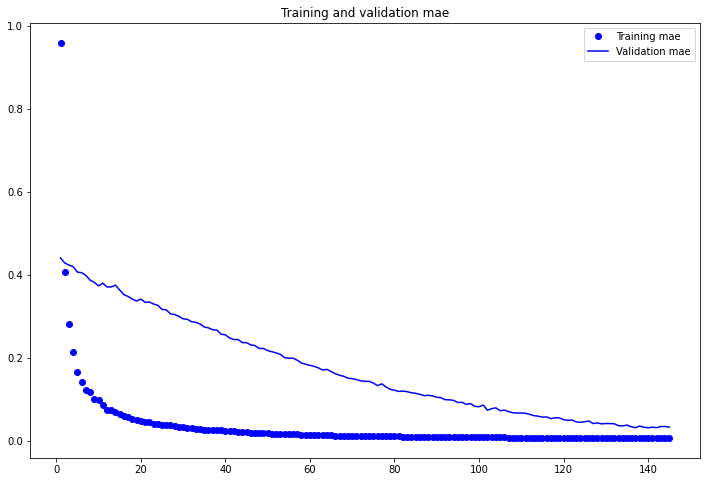

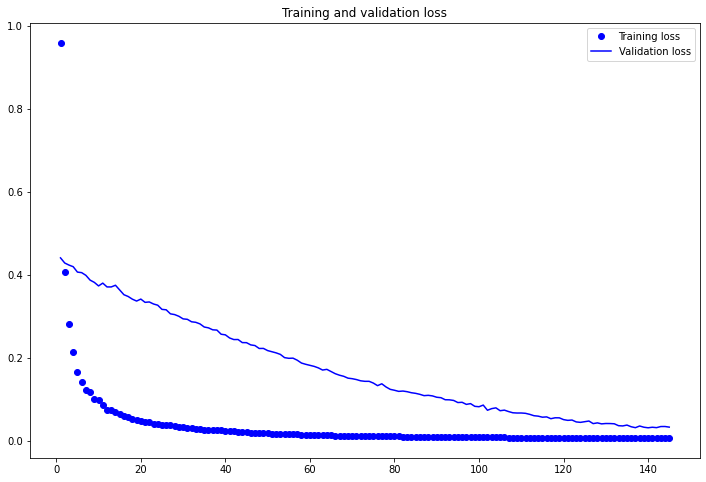

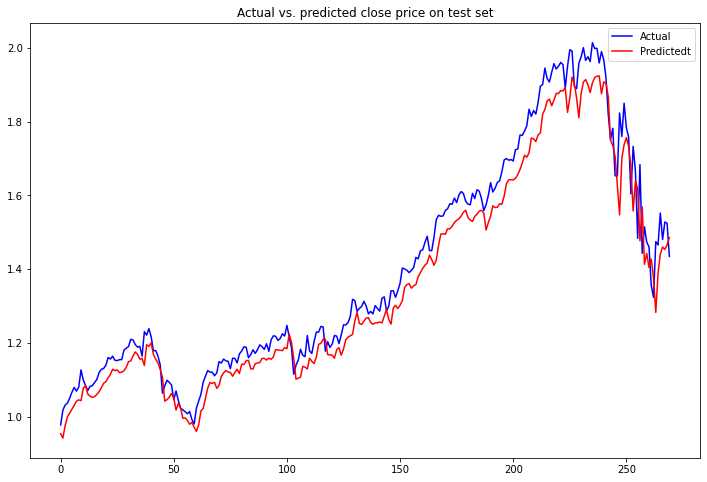

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 1980 samples, validate on 269 samples
Epoch 1/200
1980/1980 [==============================] - 3s 1ms/step - loss: 0.2121 - mae: 0.2121 - val_loss: 0.1857 - val_mae: 0.1857
Epoch 2/200
1980/1980 [==============================] - 2s 1ms/step - loss: 0.0738 - mae: 0.0738 - val_loss: 0.1302 - val_mae: 0.1302
Epoch 3/200
1980/1980 [==============================] - 2s 1ms/step - loss: 0.0537 - mae: 0.0537 - val_loss: 0.0866 - val_mae: 0.0866
Epoch 4/200
1980/1980 [==============================] - 2s 1ms/step - loss: 0.0423 - mae: 0.0423 - val_loss: 0.0886 - val_mae: 0.0886
Epoch 5/200
1980/1980 [==============================] - 2s 1ms/step - loss: 0.0368 - mae: 0.0368 - val_loss: 0.0834 - val_mae: 0.0834
Epoch 6/200
1980/1980 [==============================] - 2s 1ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0510 - val_mae: 0.0510
Epoch 7/200
1980/1980 [==============================] - 2s 1ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0487 - val_mae: 0.0487
Epoch 8/

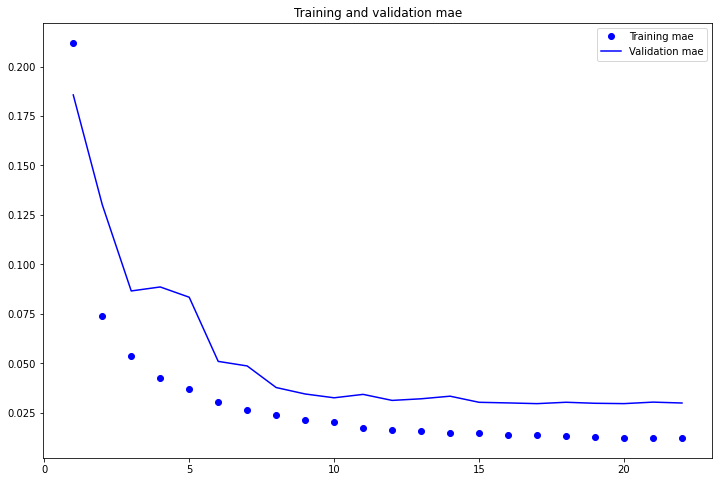

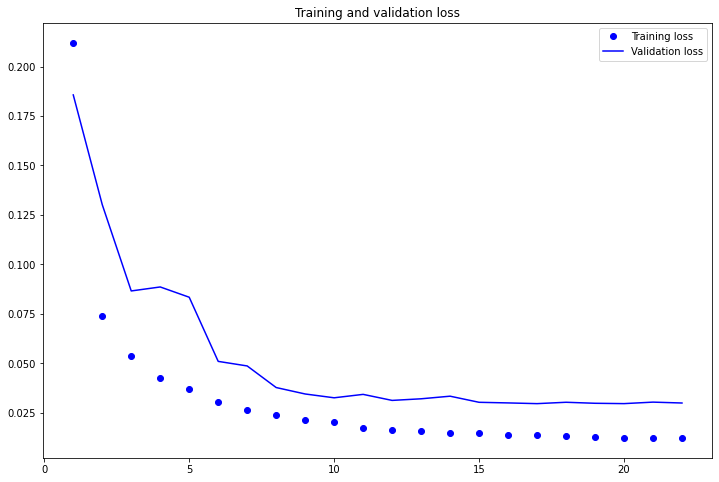

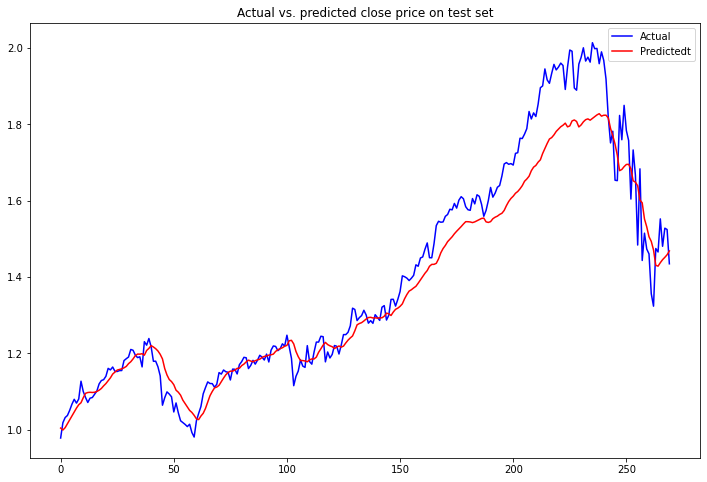

In [0]:
# LSTM model
model = Sequential()
model.add(layers.LSTM(64, recurrent_dropout=0.5, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='34'></a>
### Step 3.4: Optimizing GRU Model

<a id='341'></a>
####  Step 3.4.1: Optimizing GRU Model on One Day Lag

In [0]:
# train data are approximately half years agao 
# valida data is about half years ago to three months ago 
# test data is about three months till the end
train_data, valid_data, test_data = split_data(data, 2459, 2519)

In [0]:
scaler, train_data, valid_data, test_data = normalize_data(train_data, valid_data, test_data)

In [0]:
n_steps = 1
X_train, y_train = split_sequence_mto(train_data, n_steps)
X_valid, y_valid = split_sequence_mto(valid_data, n_steps)
X_test, y_test = split_sequence_mto(test_data, n_steps)

Train on 2458 samples, validate on 59 samples
Epoch 1/200
2458/2458 [==============================] - 1s 349us/step - loss: 0.3530 - mae: 0.3530 - val_loss: 0.9401 - val_mae: 0.9401
Epoch 2/200
2458/2458 [==============================] - 0s 196us/step - loss: 0.2220 - mae: 0.2220 - val_loss: 0.6402 - val_mae: 0.6402
Epoch 3/200
2458/2458 [==============================] - 0s 197us/step - loss: 0.1225 - mae: 0.1225 - val_loss: 0.3704 - val_mae: 0.3704
Epoch 4/200
2458/2458 [==============================] - 0s 189us/step - loss: 0.0690 - mae: 0.0690 - val_loss: 0.2100 - val_mae: 0.2100
Epoch 5/200
2458/2458 [==============================] - 0s 189us/step - loss: 0.0451 - mae: 0.0451 - val_loss: 0.1342 - val_mae: 0.1342
Epoch 6/200
2458/2458 [==============================] - 0s 189us/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0693 - val_mae: 0.0693
Epoch 7/200
2458/2458 [==============================] - 0s 192us/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0362 - val_mae: 0.

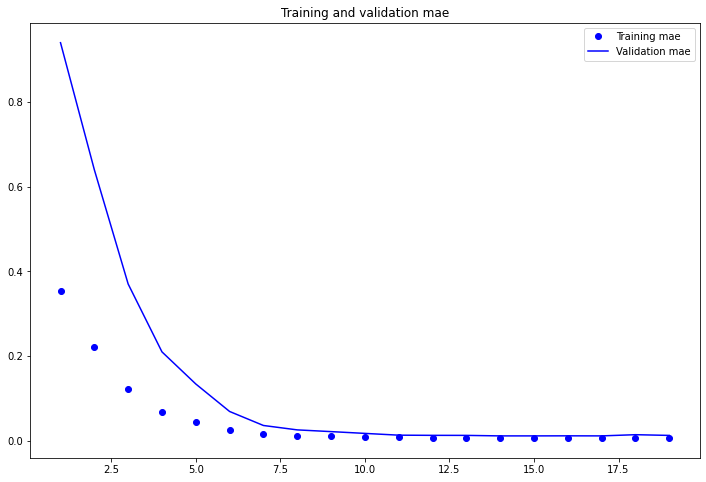

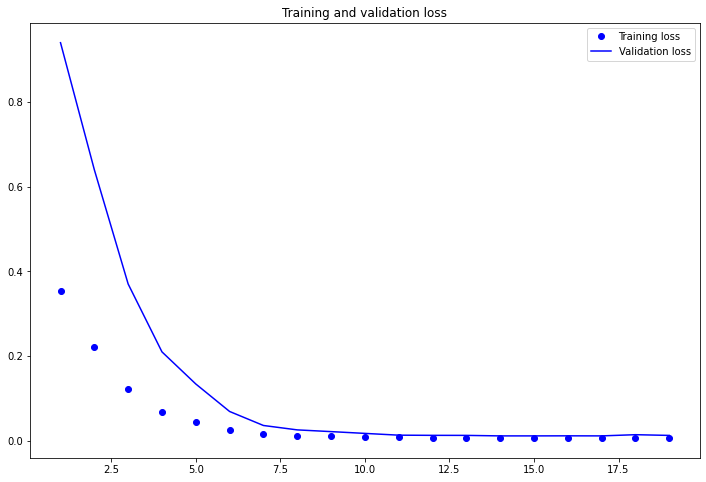

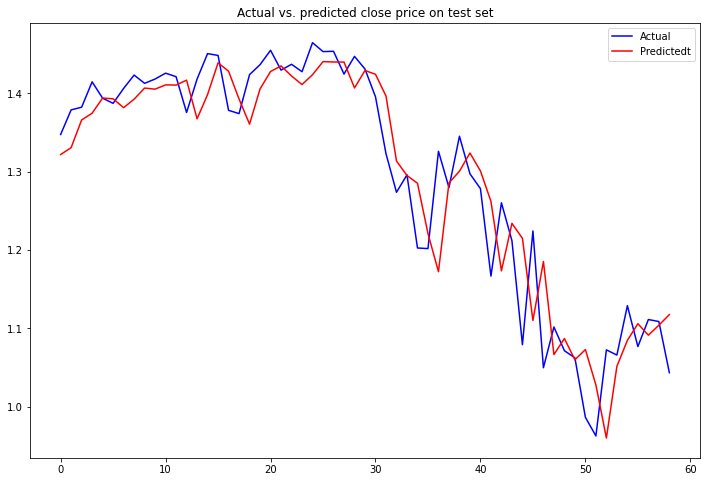

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 2458 samples, validate on 59 samples
Epoch 1/200
2458/2458 [==============================] - 1s 599us/step - loss: 0.3331 - mae: 0.3331 - val_loss: 0.9111 - val_mae: 0.9111
Epoch 2/200
2458/2458 [==============================] - 1s 321us/step - loss: 0.2156 - mae: 0.2156 - val_loss: 0.5918 - val_mae: 0.5918
Epoch 3/200
2458/2458 [==============================] - 1s 315us/step - loss: 0.1042 - mae: 0.1042 - val_loss: 0.2332 - val_mae: 0.2332
Epoch 4/200
2458/2458 [==============================] - 1s 324us/step - loss: 0.0529 - mae: 0.0529 - val_loss: 0.1115 - val_mae: 0.1115
Epoch 5/200
2458/2458 [==============================] - 1s 320us/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0211 - val_mae: 0.0211
Epoch 6/200
2458/2458 [==============================] - 1s 316us/step - loss: 0.0104 - mae: 0.0104 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 7/200
2458/2458 [==============================] - 1s 313us/step - loss: 0.0095 - mae: 0.0095 - val_loss: 0.0115 - val_mae: 0.

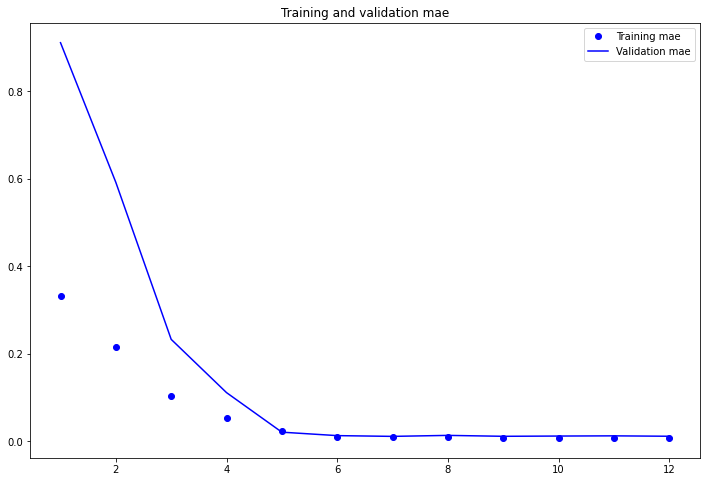

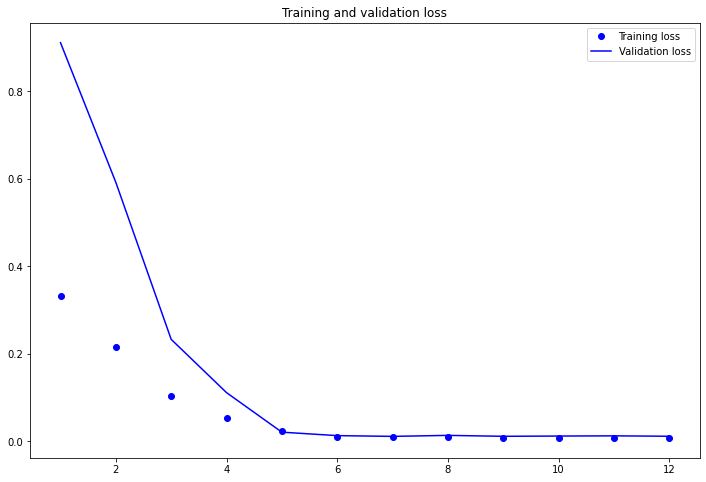

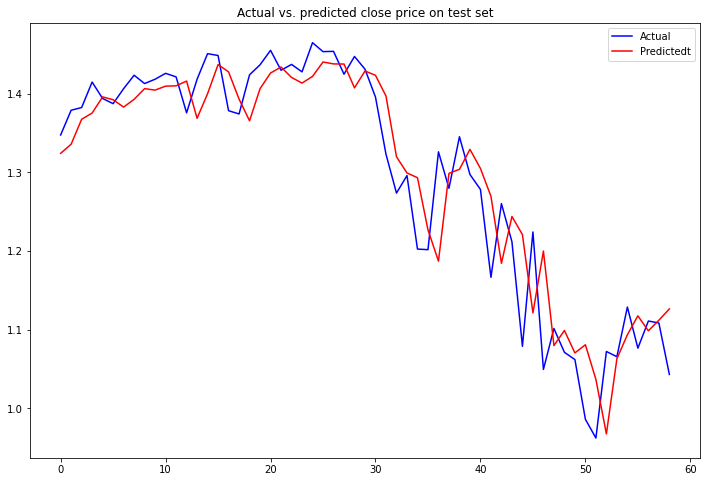

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(layers.GRU(16, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='342'></a>
#### Step 3.4.2: Optimizing GRU Model on Four Days Lags

In [0]:
n_steps = 4
X_train, y_train = split_sequence_mto(train_data, n_steps)
X_valid, y_valid = split_sequence_mto(valid_data, n_steps)
X_test, y_test = split_sequence_mto(test_data, n_steps)

Train on 2455 samples, validate on 56 samples
Epoch 1/200
2455/2455 [==============================] - 1s 573us/step - loss: 0.1299 - mae: 0.1299 - val_loss: 0.4266 - val_mae: 0.4266
Epoch 2/200
2455/2455 [==============================] - 1s 395us/step - loss: 0.0765 - mae: 0.0765 - val_loss: 0.3383 - val_mae: 0.3383
Epoch 3/200
2455/2455 [==============================] - 1s 394us/step - loss: 0.0647 - mae: 0.0647 - val_loss: 0.2709 - val_mae: 0.2709
Epoch 4/200
2455/2455 [==============================] - 1s 399us/step - loss: 0.0589 - mae: 0.0589 - val_loss: 0.2817 - val_mae: 0.2817
Epoch 5/200
2455/2455 [==============================] - 1s 396us/step - loss: 0.0505 - mae: 0.0505 - val_loss: 0.2562 - val_mae: 0.2562
Epoch 6/200
2455/2455 [==============================] - 1s 401us/step - loss: 0.0452 - mae: 0.0452 - val_loss: 0.2567 - val_mae: 0.2567
Epoch 7/200
2455/2455 [==============================] - 1s 392us/step - loss: 0.0387 - mae: 0.0387 - val_loss: 0.2468 - val_mae: 0.

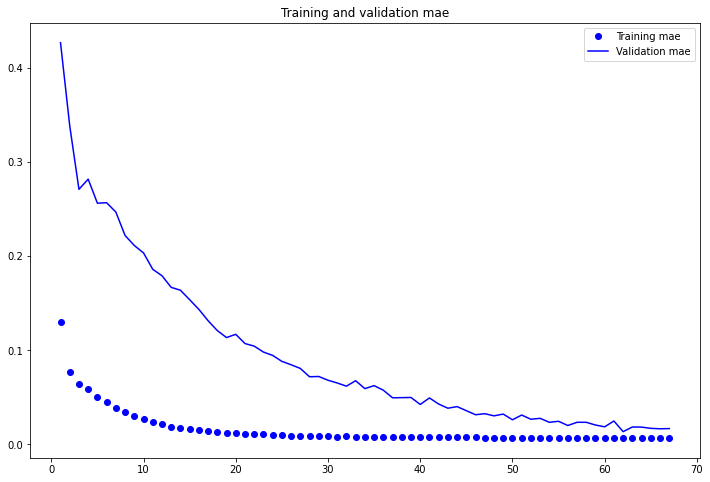

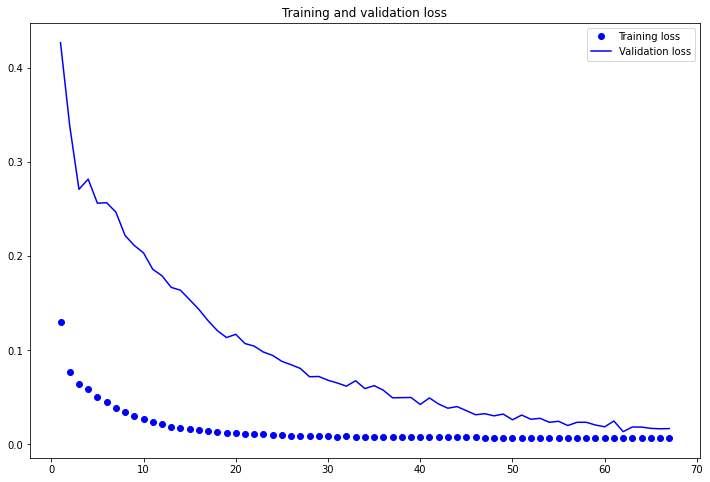

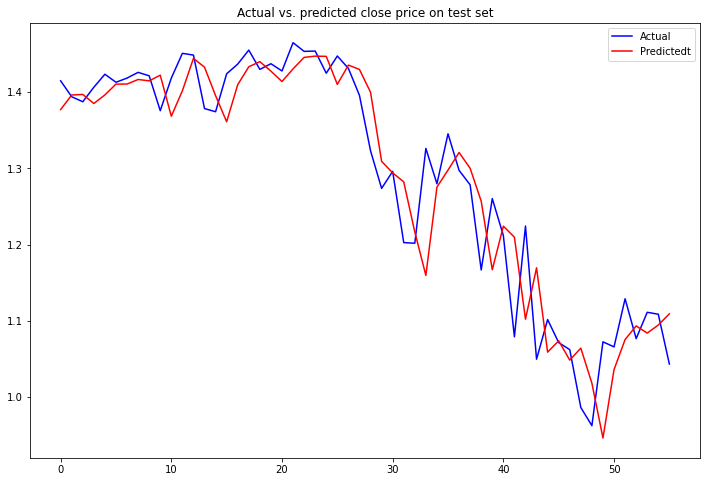

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 2455 samples, validate on 56 samples
Epoch 1/200
2455/2455 [==============================] - 3s 1ms/step - loss: 0.2763 - mae: 0.2763 - val_loss: 0.5381 - val_mae: 0.5381
Epoch 2/200
2455/2455 [==============================] - 2s 730us/step - loss: 0.0877 - mae: 0.0877 - val_loss: 0.4287 - val_mae: 0.4287
Epoch 3/200
2455/2455 [==============================] - 2s 741us/step - loss: 0.0722 - mae: 0.0722 - val_loss: 0.3836 - val_mae: 0.3836
Epoch 4/200
2455/2455 [==============================] - 2s 735us/step - loss: 0.0660 - mae: 0.0660 - val_loss: 0.3734 - val_mae: 0.3734
Epoch 5/200
2455/2455 [==============================] - 2s 737us/step - loss: 0.0588 - mae: 0.0588 - val_loss: 0.3119 - val_mae: 0.3119
Epoch 6/200
2455/2455 [==============================] - 2s 746us/step - loss: 0.0544 - mae: 0.0544 - val_loss: 0.3362 - val_mae: 0.3362
Epoch 7/200
2455/2455 [==============================] - 2s 754us/step - loss: 0.0518 - mae: 0.0518 - val_loss: 0.3172 - val_mae: 0.31

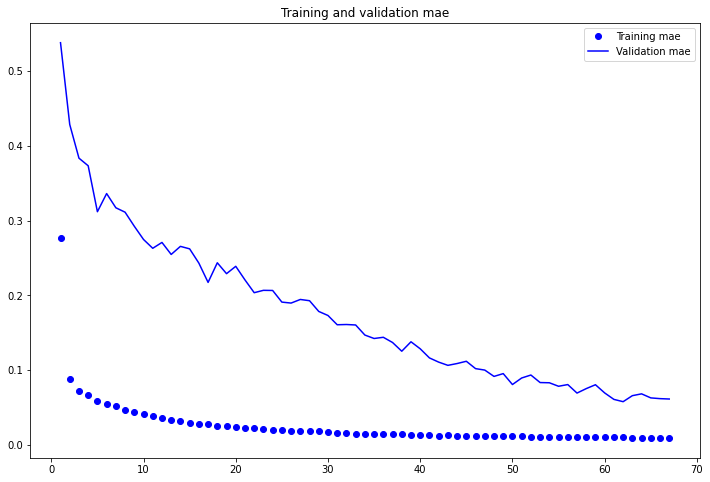

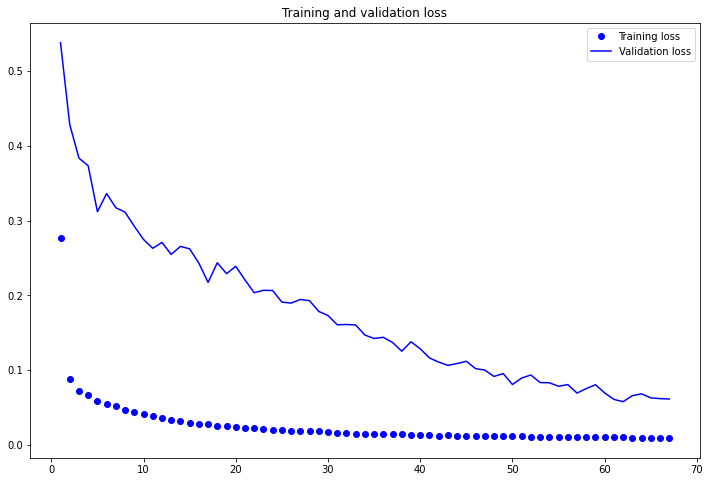

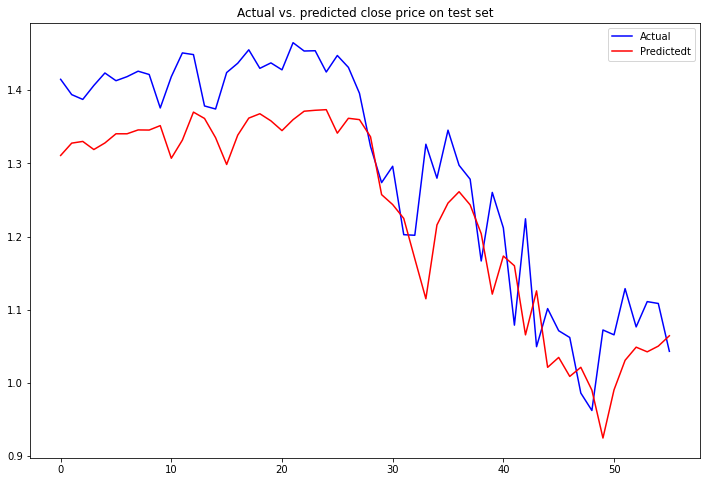

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(layers.GRU(16, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='343'></a>
#### Step 3.4.3: Optimizing GRU Model on Ten Days Lags

In [0]:
n_steps = 10
X_train, y_train = split_sequence_mto(train_data, n_steps)
X_valid, y_valid = split_sequence_mto(valid_data, n_steps)
X_test, y_test = split_sequence_mto(test_data, n_steps)

Train on 2449 samples, validate on 50 samples
Epoch 1/200
2449/2449 [==============================] - 2s 956us/step - loss: 0.2231 - mae: 0.2231 - val_loss: 0.8218 - val_mae: 0.8218
Epoch 2/200
2449/2449 [==============================] - 2s 797us/step - loss: 0.1473 - mae: 0.1473 - val_loss: 0.7427 - val_mae: 0.7427
Epoch 3/200
2449/2449 [==============================] - 2s 807us/step - loss: 0.1050 - mae: 0.1050 - val_loss: 0.7021 - val_mae: 0.7021
Epoch 4/200
2449/2449 [==============================] - 2s 807us/step - loss: 0.0823 - mae: 0.0823 - val_loss: 0.6655 - val_mae: 0.6655
Epoch 5/200
2449/2449 [==============================] - 2s 822us/step - loss: 0.0672 - mae: 0.0672 - val_loss: 0.6177 - val_mae: 0.6177
Epoch 6/200
2449/2449 [==============================] - 2s 800us/step - loss: 0.0575 - mae: 0.0575 - val_loss: 0.5862 - val_mae: 0.5862
Epoch 7/200
2449/2449 [==============================] - 2s 820us/step - loss: 0.0482 - mae: 0.0482 - val_loss: 0.5464 - val_mae: 0.

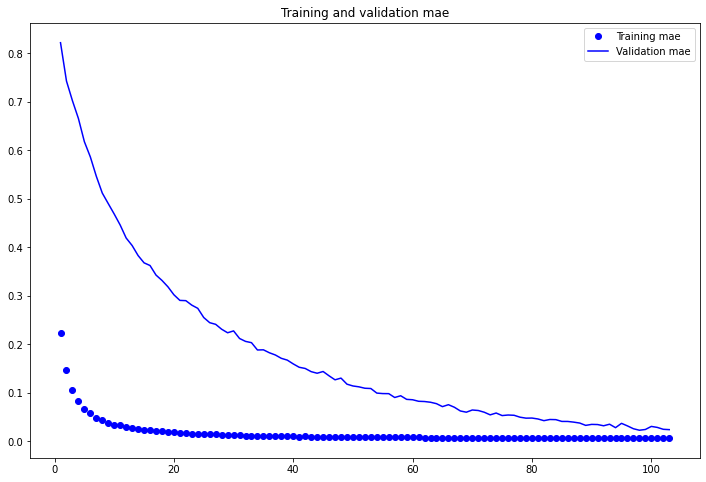

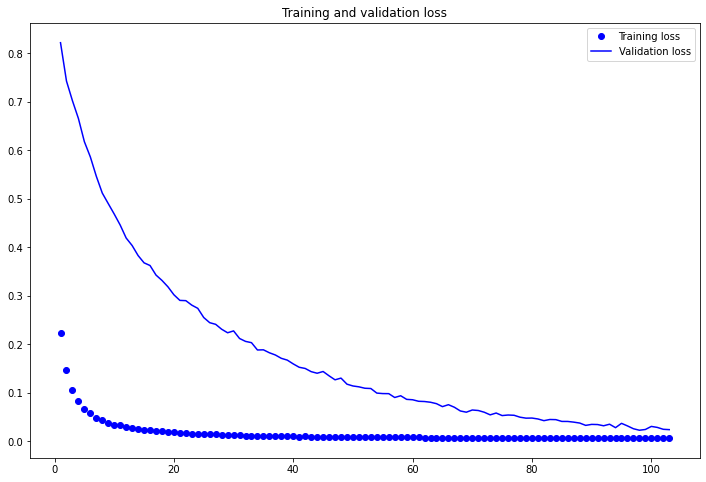

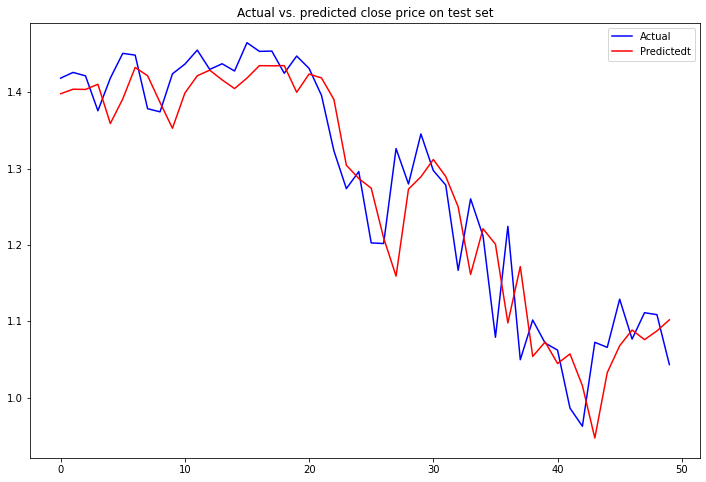

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 2449 samples, validate on 50 samples
Epoch 1/200
2449/2449 [==============================] - 5s 2ms/step - loss: 0.2538 - mae: 0.2538 - val_loss: 0.9678 - val_mae: 0.9678
Epoch 2/200
2449/2449 [==============================] - 4s 2ms/step - loss: 0.1614 - mae: 0.1614 - val_loss: 0.8902 - val_mae: 0.8902
Epoch 3/200
2449/2449 [==============================] - 4s 2ms/step - loss: 0.1244 - mae: 0.1244 - val_loss: 0.8440 - val_mae: 0.8440
Epoch 4/200
2449/2449 [==============================] - 4s 2ms/step - loss: 0.1043 - mae: 0.1043 - val_loss: 0.8036 - val_mae: 0.8036
Epoch 5/200
2449/2449 [==============================] - 4s 2ms/step - loss: 0.0927 - mae: 0.0927 - val_loss: 0.7567 - val_mae: 0.7567
Epoch 6/200
2449/2449 [==============================] - 4s 2ms/step - loss: 0.0775 - mae: 0.0775 - val_loss: 0.7344 - val_mae: 0.7344
Epoch 7/200
2449/2449 [==============================] - 4s 2ms/step - loss: 0.0715 - mae: 0.0715 - val_loss: 0.7071 - val_mae: 0.7071
Epoch 8/2

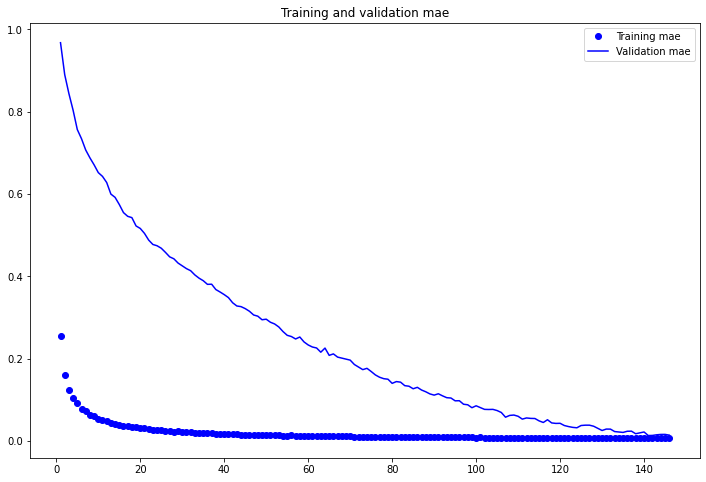

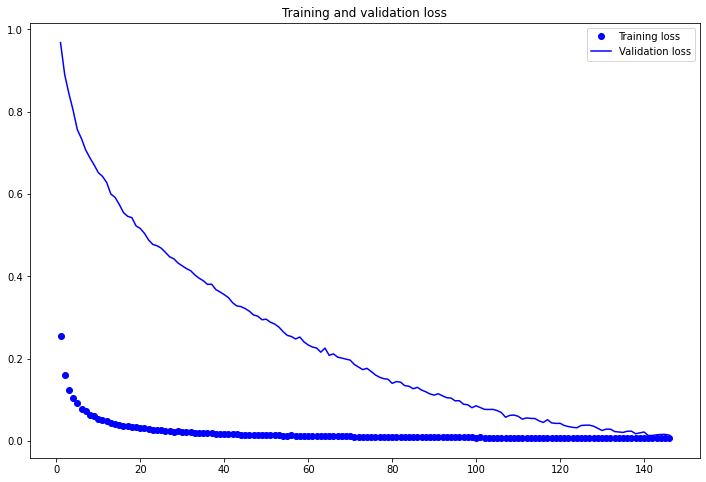

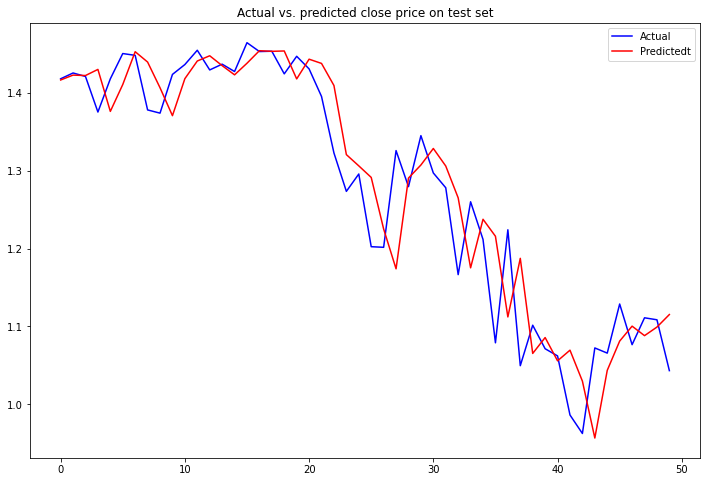

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(layers.GRU(16, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='344'></a>
#### Step 3.4.4:Best Many-to-One GRU Model with Four Days Lags & One Day Delay

In [0]:
def load_data(ticker='AAPL', start=datetime.date(2010, 1, 1), end=datetime.date.today(),  n_steps=4):
  """
  Load the ticker data from start date to end date.
  Transform and normalize the dataset.
  """
  df = load_stock(ticker, start, end)
  data = df.drop(['Date', 'Adj Close'], axis=1)
  scaler = MinMaxScaler()
  data = scaler.fit_transform(data)
  X_train, y_train = split_sequence_mto(data, n_steps)

  return scaler, X_train, y_train

In [0]:
scaler, X_train, y_train = load_data()

# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
model.fit(X_train, y_train, epochs=62, verbose=0)

In [0]:
y_pred = model.predict(X_train[-1:, :])
print('Predicted price on {}: {}'.format(datetime.date.today(), y_pred * scaler.data_range_[3] + scaler.data_min_[3]))

Predicted price on 2020-04-21: [[280.81973]]


<a id='4'></a>
## Step 4: Many-to-Many Modeling

<a id='41'></a>
### Step 4.1: Generating Timeseries Samples and their Targets

In [0]:
# Adapted from J. Brownlee
def split_sequence_mtm(data, n_steps_in, n_steps_out):
  """
  Split a sequence into many to many or one to many depending on the time setps.
  """
  X, Y = [], []
  for i in np.arange(len(data)):
    input_end_idx = i + n_steps_in
    output_end_idx = input_end_idx + n_steps_out
    # Check if the idx is out of bound
    if output_end_idx > len(data) - 1:
      break
    x, y = data[i:input_end_idx, :], data[input_end_idx:output_end_idx, 3]
    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)

In [0]:
train_data, valid_data, test_data = split_data(data, 2459, 2519)

scaler, train_data, valid_data, test_data = normalize_data(train_data, valid_data, test_data)

n_steps_in, n_steps_out, n_features = 4, 4, 5
X_train, y_train = split_sequence_mtm(train_data, n_steps_in, n_steps_out)
X_valid, y_valid = split_sequence_mtm(valid_data, n_steps_in, n_steps_out)
X_test, y_test = split_sequence_mtm(test_data, n_steps_in, n_steps_out)


<a id='42'></a>
### Step 4.2: Developing a Model

In [0]:
def eval_mae_mtm(model, scaler, n_steps_out, X_valid, y_valid, X_test, y_test):
  """
  Print MAE on train, valid and test set.
  """
  preds_y_valid = X_valid[:, -n_steps_out:, 3]
  print('\nNormalized base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)))
  print('Original base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)) * scaler.data_range_[3])

  preds_y_test = X_test[:, -n_steps_out:, 3]
  print('Normalized base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)))
  print('Original base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)) * scaler.data_range_[3])

  print('Validation MAE:', model.evaluate(X_valid, y_valid)[1])
  print('Original validation MAE:', model.evaluate(X_valid, y_valid)[1] * scaler.data_range_[3])
  print('Test MAE:', model.evaluate(X_test, y_test)[1])
  print('Original test MAE:', model.evaluate(X_test, y_test)[1] * scaler.data_range_[3])

In [0]:
# Very-common base-line model
# Always use today's price as predicted price for tomorrow
preds_y_valid = X_valid[:, -n_steps_out:, 3]
print('Normalized base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)))
print('Original base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)) * scaler.data_range_[3])

preds_y_test = X_test[:, -n_steps_out:, 3]
print('Normalized base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)))
print('Original base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)) * scaler.data_range_[3])

Normalized base line MAE on validation data: 0.026264724310142637
Original base line MAE on validation data: 5.374663279606749
Normalized base line MAE on test data: 0.06180586094611616
Original base line MAE on test data: 12.647598633399376


Train on 2451 samples, validate on 52 samples
Epoch 1/200
2451/2451 [==============================] - 0s 142us/step - loss: 0.2847 - mae: 0.2847 - val_loss: 0.4529 - val_mae: 0.4529
Epoch 2/200
2451/2451 [==============================] - 0s 78us/step - loss: 0.2125 - mae: 0.2125 - val_loss: 0.2549 - val_mae: 0.2549
Epoch 3/200
2451/2451 [==============================] - 0s 82us/step - loss: 0.1715 - mae: 0.1715 - val_loss: 0.1721 - val_mae: 0.1721
Epoch 4/200
2451/2451 [==============================] - 0s 89us/step - loss: 0.1524 - mae: 0.1524 - val_loss: 0.1402 - val_mae: 0.1402
Epoch 5/200
2451/2451 [==============================] - 0s 98us/step - loss: 0.1362 - mae: 0.1362 - val_loss: 0.1486 - val_mae: 0.1486
Epoch 6/200
2451/2451 [==============================] - 0s 106us/step - loss: 0.1237 - mae: 0.1237 - val_loss: 0.1533 - val_mae: 0.1533
Epoch 7/200
2451/2451 [==============================] - 0s 98us/step - loss: 0.1140 - mae: 0.1140 - val_loss: 0.1594 - val_mae: 0.1594


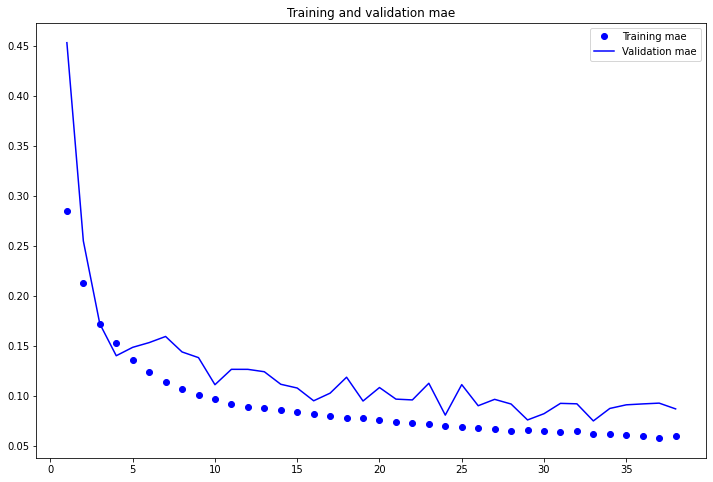

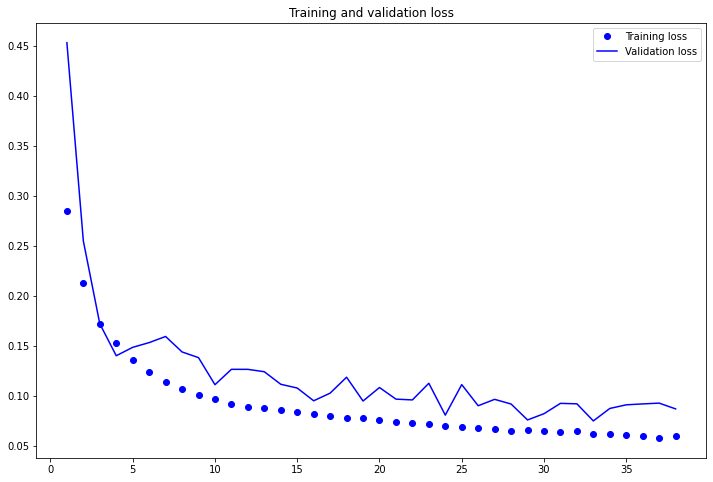

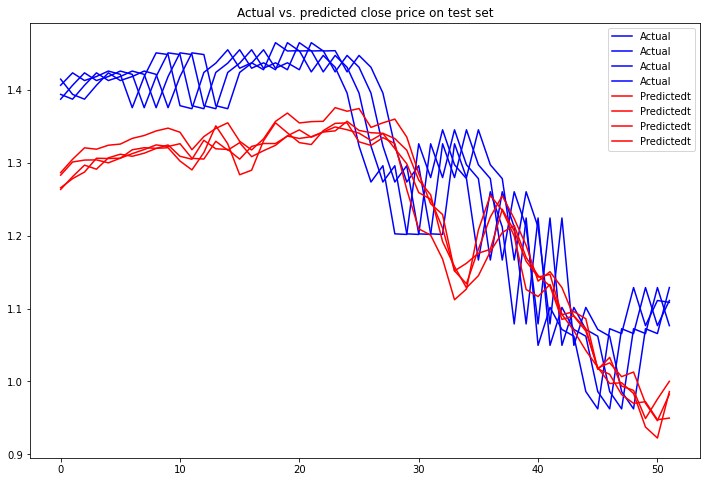

In [0]:
# MLP model
model = Sequential()
model.add(layers.Flatten(input_shape=(n_steps_in, n_features)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae_mtm(model, scaler, n_steps_out, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 2451 samples, validate on 52 samples
Epoch 1/200
2451/2451 [==============================] - 1s 570us/step - loss: 0.2997 - mae: 0.2997 - val_loss: 0.8015 - val_mae: 0.8015
Epoch 2/200
2451/2451 [==============================] - 1s 412us/step - loss: 0.1333 - mae: 0.1333 - val_loss: 0.4492 - val_mae: 0.4492
Epoch 3/200
2451/2451 [==============================] - 1s 406us/step - loss: 0.0790 - mae: 0.0790 - val_loss: 0.3700 - val_mae: 0.3700
Epoch 4/200
2451/2451 [==============================] - 1s 384us/step - loss: 0.0657 - mae: 0.0657 - val_loss: 0.3247 - val_mae: 0.3247
Epoch 5/200
2451/2451 [==============================] - 1s 398us/step - loss: 0.0585 - mae: 0.0585 - val_loss: 0.2977 - val_mae: 0.2977
Epoch 6/200
2451/2451 [==============================] - 1s 378us/step - loss: 0.0548 - mae: 0.0548 - val_loss: 0.2740 - val_mae: 0.2740
Epoch 7/200
2451/2451 [==============================] - 1s 431us/step - loss: 0.0492 - mae: 0.0492 - val_loss: 0.2626 - val_mae: 0.

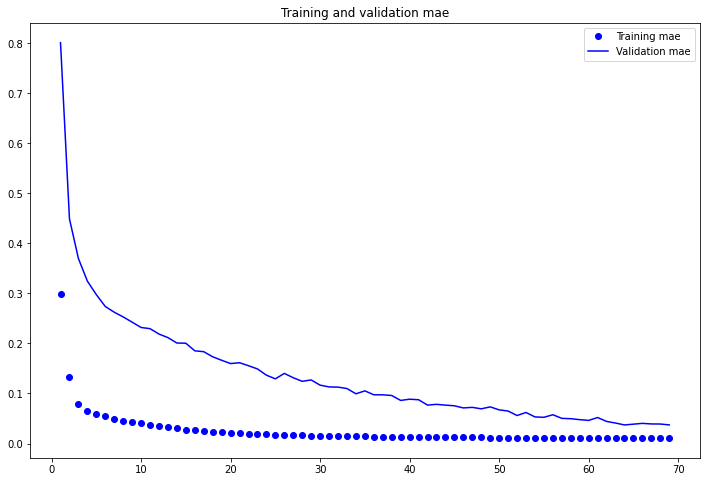

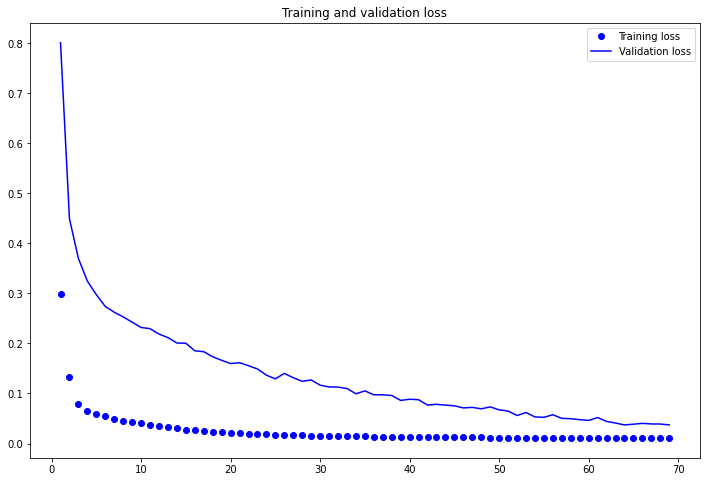

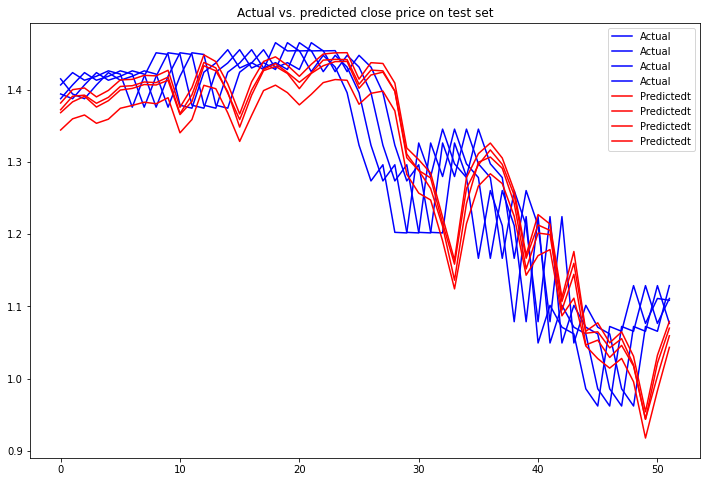

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps_in, n_features)))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae_mtm(model, scaler, n_steps_out, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 2451 samples, validate on 52 samples
Epoch 1/200
2451/2451 [==============================] - 1s 460us/step - loss: 0.3010 - mae: 0.3010 - val_loss: 0.7668 - val_mae: 0.7668
Epoch 2/200
2451/2451 [==============================] - 1s 312us/step - loss: 0.1550 - mae: 0.1550 - val_loss: 0.2967 - val_mae: 0.2967
Epoch 3/200
2451/2451 [==============================] - 1s 328us/step - loss: 0.0594 - mae: 0.0594 - val_loss: 0.0851 - val_mae: 0.0851
Epoch 4/200
2451/2451 [==============================] - 1s 328us/step - loss: 0.0399 - mae: 0.0399 - val_loss: 0.0511 - val_mae: 0.0511
Epoch 5/200
2451/2451 [==============================] - 1s 322us/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.0399 - val_mae: 0.0399
Epoch 6/200
2451/2451 [==============================] - 1s 376us/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0272 - val_mae: 0.0272
Epoch 7/200
2451/2451 [==============================] - 1s 316us/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0269 - val_mae: 0.

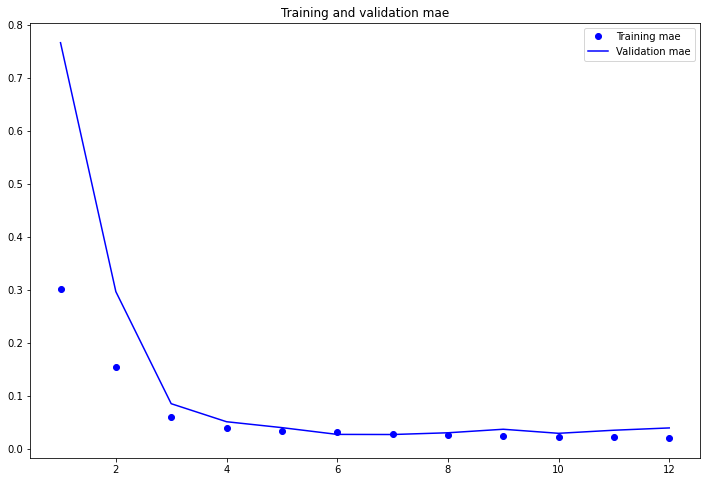

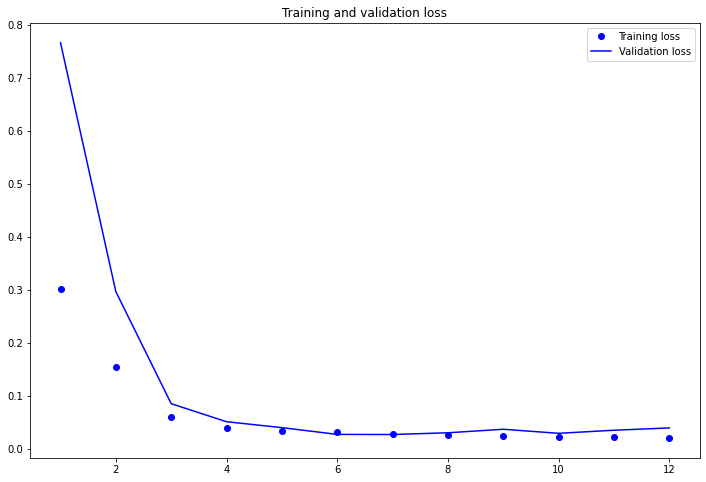

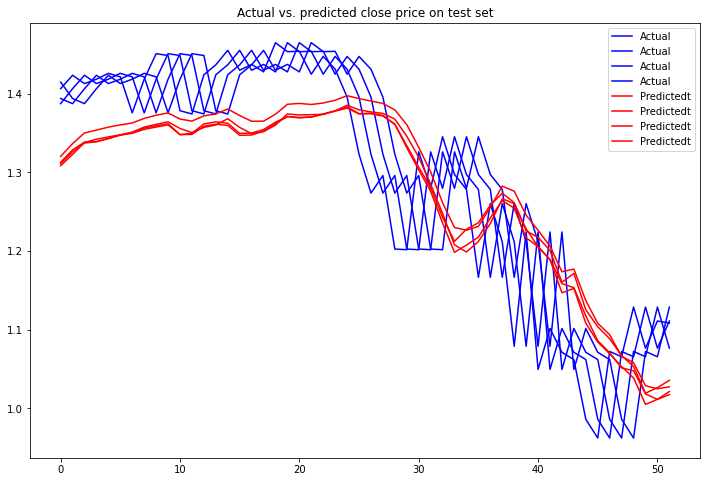

In [0]:
# LSTM model
model = Sequential()
model.add(layers.LSTM(64, recurrent_dropout=0.5, input_shape=(n_steps_in, n_features)))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae_mtm(model, scaler, n_steps_out, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='43'></a>
### Step 4.3: Optimizing GRU Model

Train on 2451 samples, validate on 52 samples
Epoch 1/200
2451/2451 [==============================] - 3s 1ms/step - loss: 0.2112 - mae: 0.2112 - val_loss: 0.4763 - val_mae: 0.4763
Epoch 2/200
2451/2451 [==============================] - 2s 698us/step - loss: 0.0782 - mae: 0.0782 - val_loss: 0.3777 - val_mae: 0.3777
Epoch 3/200
2451/2451 [==============================] - 2s 791us/step - loss: 0.0628 - mae: 0.0628 - val_loss: 0.3318 - val_mae: 0.3318
Epoch 4/200
2451/2451 [==============================] - 2s 842us/step - loss: 0.0586 - mae: 0.0586 - val_loss: 0.3115 - val_mae: 0.3115
Epoch 5/200
2451/2451 [==============================] - 2s 760us/step - loss: 0.0542 - mae: 0.0542 - val_loss: 0.2892 - val_mae: 0.2892
Epoch 6/200
2451/2451 [==============================] - 2s 720us/step - loss: 0.0506 - mae: 0.0506 - val_loss: 0.2911 - val_mae: 0.2911
Epoch 7/200
2451/2451 [==============================] - 2s 758us/step - loss: 0.0479 - mae: 0.0479 - val_loss: 0.2953 - val_mae: 0.29

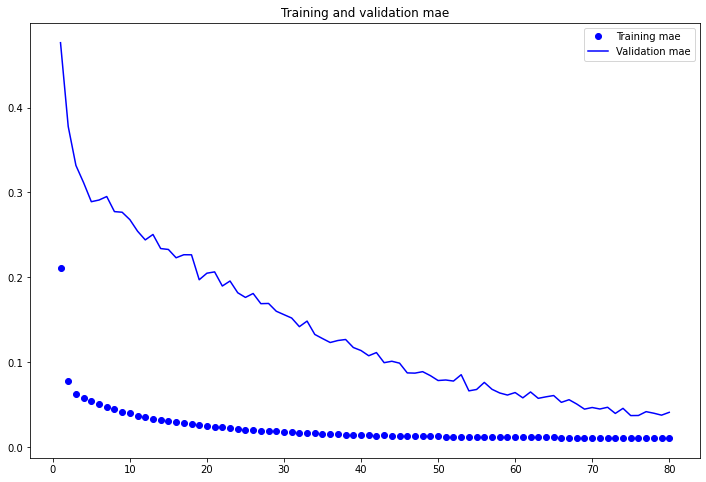

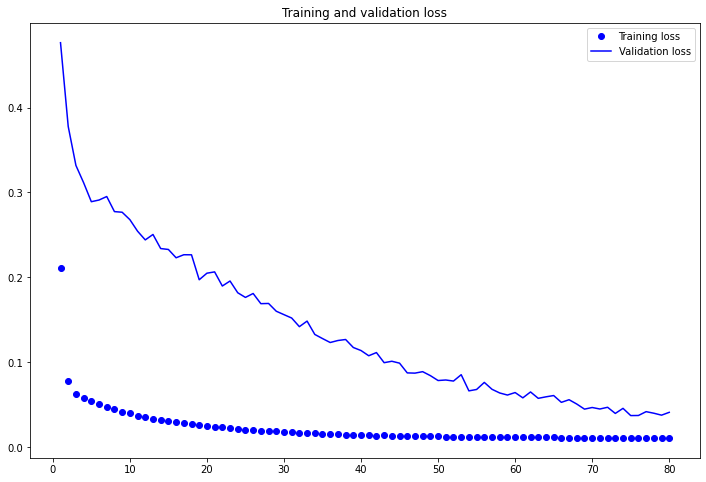

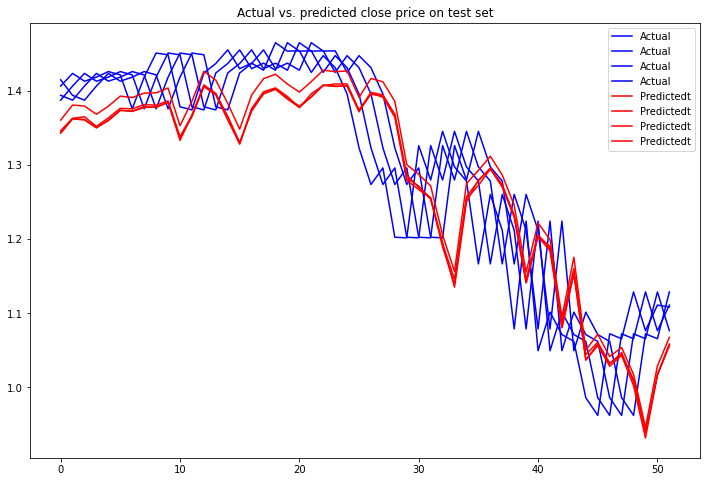

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(layers.GRU(32, recurrent_dropout=0.4))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae_mtm(model, scaler, n_steps_in, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='4'></a>
### Step 4.4: Best Many-to-Many GRU Model with Four Days Lags & Four Days Delays

In [0]:
def load_data_mtm(ticker='AAPL', start=datetime.date(2010, 1, 1), 
                  end=datetime.date.today(),  n_steps_in=4, n_steps_out=4):
  """
  Load the ticker data from start date to end date.
  Transform and normalize the dataset.
  """
  df = load_stock(ticker, start, end)
  data = df.drop(['Date', 'Adj Close'], axis=1)
  scaler = MinMaxScaler()
  data = scaler.fit_transform(data)
  X_train, y_train = split_sequence_mtm(data, n_steps_in, n_steps_out)

  return scaler, X_train, y_train

n_steps_in, n_steps_out, n_features = 4, 4, 5
scaler, X_train, y_train = load_data_mtm()

# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps_in, n_features)))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=69, verbose=0)

y_pred = model.predict(X_train[-1:, :, :])
print('Predicted price on the following {} days starting from {}: {}'.format(n_steps_out, datetime.date.today(), y_pred * scaler.data_range_[3] + scaler.data_min_[3]))

Predicted price on the following 4 days starting from 2020-04-22: [[277.49625 276.19232 278.3131  279.26086]]


<a id='5'></a>
## Step 5: Putting All Together

In [0]:
# Intall pandas_datareader
!pip -q install pandas_datareader

# Import necessary libraries
import pandas_datareader.data as web
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,8)

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')


class GRURegressor:
  """
  Author: Christopher W. Hong
  Data: 2020.04.21

  This class implement a many to many RNN regressor with GRU units.
  """
  
  def __init__(self, ticker_name='AAPL', 
               start_date=datetime.datetime(2010,1,1), 
               end_date=datetime.datetime.today().date() - datetime.timedelta(days=1),
               n_steps_in=4,
               n_steps_out=4,
               test_size=0.05):
    self.ticker_name = ticker_name
    self.start_date = start_date
    self.end_date = end_date
    self.n_steps_in = n_steps_in
    self.n_steps_out = n_steps_out
    self.test_size= test_size

    assert start_date.date() <= end_date
    assert n_steps_in >= 1
    assert n_steps_out >= 1

  def load_stock(self):
    """
    Load ticker from start date till end date into a DataFrame.
    """
    df = web.DataReader(self.ticker_name, 'yahoo', self.start_date , self.end_date)
    df = df.reset_index()
    df = df.drop(['Date', 'Adj Close'], axis=1)
    return df

  def split_data(self, data):
    """
    Split the data into train & test set.
    """
    self.n_features = data.shape[1]
    data_size = len(data)
    self.train_idx = int((data_size) * (1 - self.test_size))
    data = data.values
    train_data = data[:self.train_idx, :]
    test_data = data[self.train_idx:, :]
    return train_data, test_data

  def normalize_data(self, train_data, test_data):
    """
    Normalize the data.
    """
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    self.data_range = np.array([scaler.data_range_[3]])
    self.data_min = np.array([scaler.data_min_[3]])
    return train_data, test_data

  def split_sequence(self, data):
    """
    Split a sequence into arbitrary many to many shape.
    """
    X, Y = [], []
    for i in np.arange(len(data)):
      input_end_idx = i + self.n_steps_in
      output_end_idx = input_end_idx + self.n_steps_out
      # Check if the idx is out of bound
      if output_end_idx > len(data) - 1:
        break
      x, y = data[i:input_end_idx, :], data[input_end_idx:output_end_idx, 3]
      X.append(x)
      Y.append(y)
    return np.array(X), np.array(Y)

  def load_data(self):
    """
    Load the data into ready-to-train and test format.
    """
    df = self.load_stock()
    train_data, test_data = self.split_data(df)
    train_data, test_data = self.normalize_data(train_data, test_data)
    X_train, y_train = self.split_sequence(train_data)
    X_test, y_test = self.split_sequence(test_data)
    return X_train, X_test, y_train, y_test

  def fit(self, X_train, y_train, n_units=64, dropout=0.4, epochs=69, verbose=0):
    """
    Train the GRU model.
    """
    self.model = Sequential()
    self.model.add(layers.GRU(n_units, recurrent_dropout=dropout, 
                         input_shape=(self.n_steps_in, self.n_features)))
    self.model.add(layers.Dense(self.n_steps_out))
    self.model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
    history = self.model.fit(X_train, y_train, epochs=69, verbose=verbose)
    return history

  def evaluate(self, X_test, y_test):
    """
    Evaluate the loss and mae.
    """
    return self.model.evaluate(X_test, y_test)[1] * self.data_range

  def predict(self, X_test):
    """
    Make predictions on X_test.
    """
    return self.model.predict(X_test) * self.data_range + self.data_min

  def plot(self, y_test, y_preds):
    """
    Plot the true targets against the predicted ones.
    """
    y_test = y_test * self.data_range + self.data_min
    if self.n_steps_out > 1:
      for i in np.arange(self.n_steps_out):
        plt.plot(y_test[:, i], 'b', label='Actual')
        plt.plot(y_preds[:, i], 'r', label='Predicted')
        plt.title('Actual vs. Predicted Close Price @ Day ' + str(i+1))
        plt.legend()
        plt.show();
      plt.plot(y_test, 'b', label='Actual')
      plt.plot(y_preds, 'r', label='Predicted')
      plt.title('Actual vs. Predicted Close Price')
      plt.legend()
      plt.show();
    else:
        plt.plot(y_test, 'b', label='Actual')
        plt.plot(y_preds, 'r', label='Predicted')
        plt.title('Actual vs. Predicted Close Price')
        plt.legend()
        plt.show();

In [0]:
# Initialize the GRU model
# Adapt the n_steps_in & n_steps_out parameters
# to manipulate the sequence to sequence i.e. m to 1, 1 to 1, 1 to m, m to m
model = GRURegressor(n_steps_out=5)

# Load train and test datasets
X_train, X_test, y_train, y_test = model.load_data()
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (2453, 4, 5)
X_test shape: (121, 4, 5)
y_train shape: (2453, 5)
y_test shape: (121, 5)


121/121 [==============================] - 0s 588us/step
MAE on test set: [10.08728686]


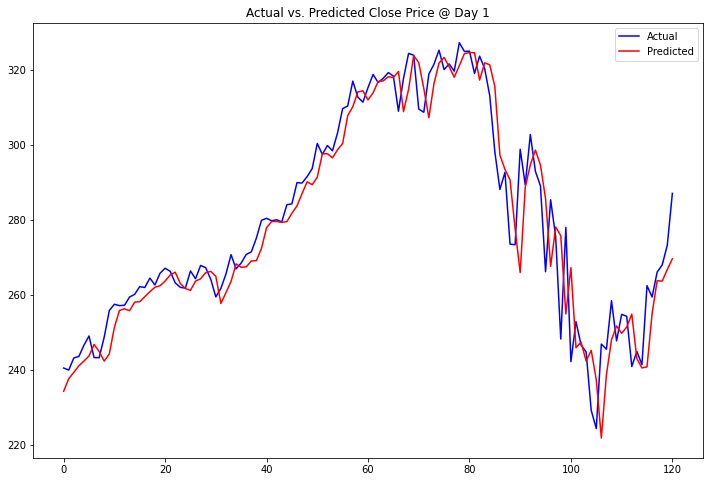

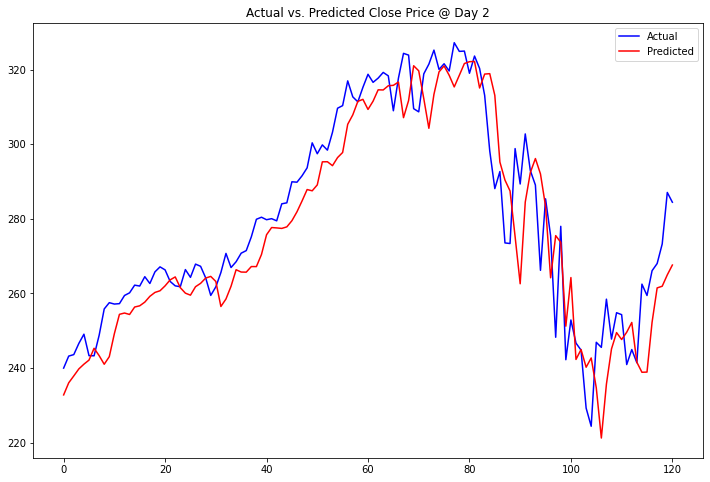

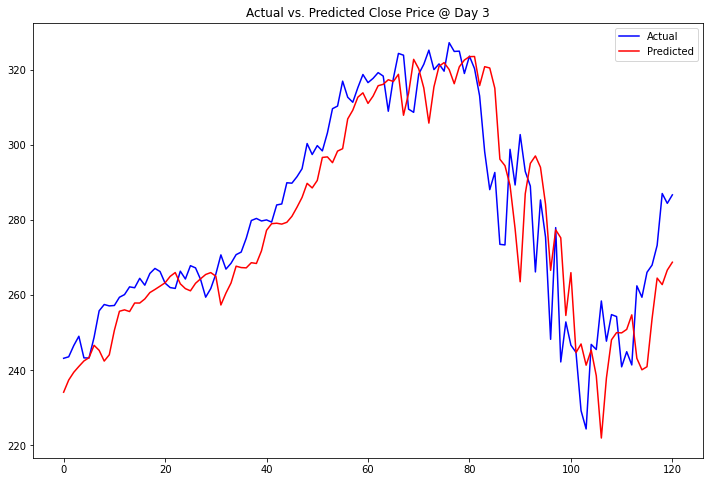

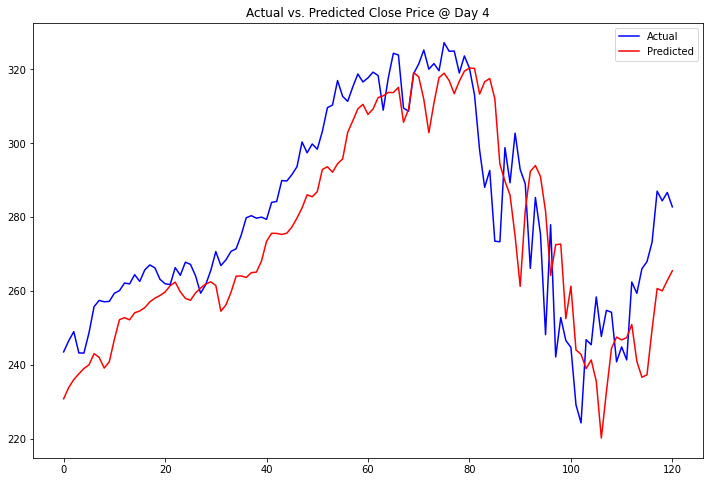

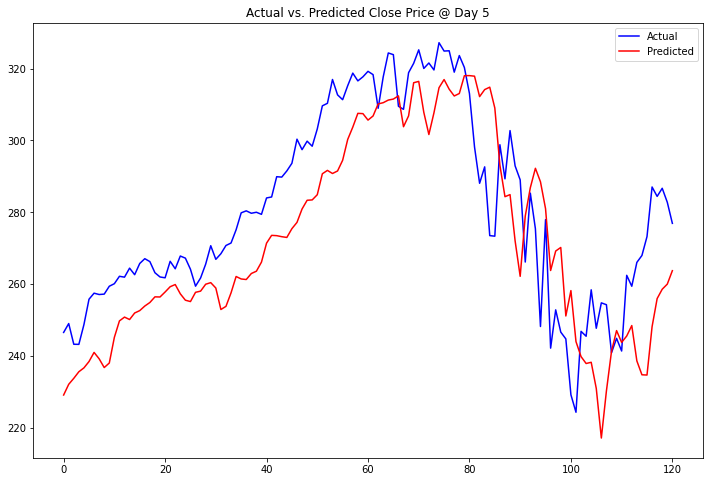

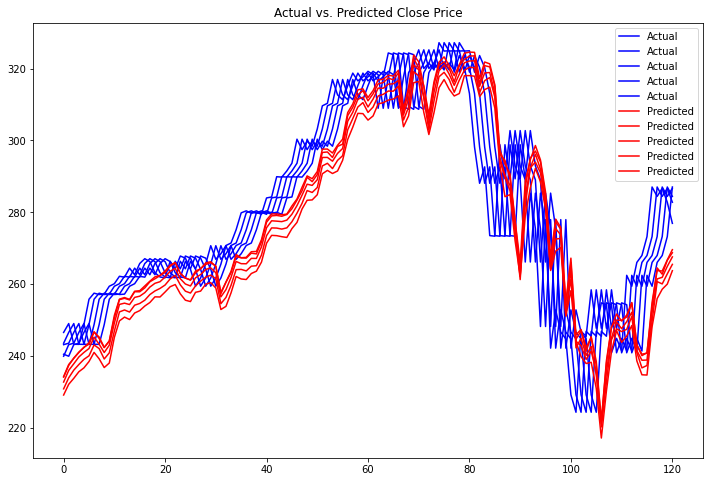

In [0]:
# Train the model
# Adapt the n_units, epochs, dropout parameters to train the GRU model
# Set verbose=1 if training progress is needed
history = model.fit(X_train, y_train)

# Evaluate MAE
print('MAE on test set:', model.evaluate(X_test, y_test))

# Make predictions
y_preds = model.predict(X_test)

# Plot actual vs. predicted
model.plot(y_test, y_preds)

125/125 [==============================] - 0s 554us/step


array([6.15088882])

X_train shape: (2457, 4, 5)
X_test shape: (125, 4, 5)
y_train shape: (2457, 1)
y_test shape: (125, 1)
125/125 [==============================] - 0s 603us/step
MAE on test set: [5.37796911]


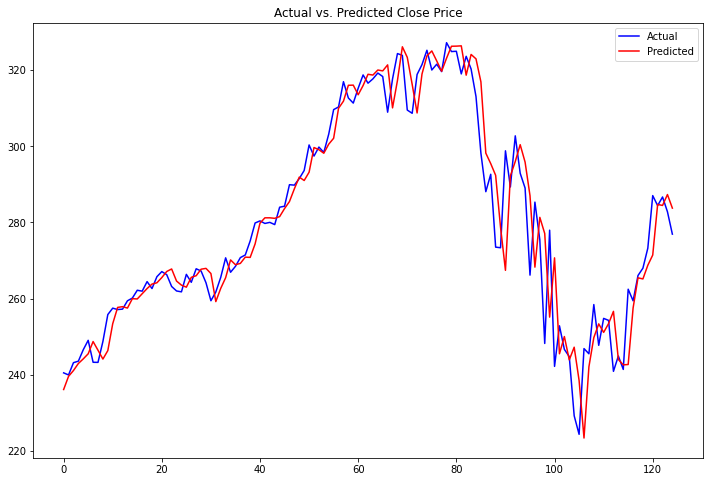

X_train shape: (2460, 1, 5)
X_test shape: (128, 1, 5)
y_train shape: (2460, 1)
y_test shape: (128, 1)
128/128 [==============================] - 0s 581us/step
MAE on test set: [6.24117489]


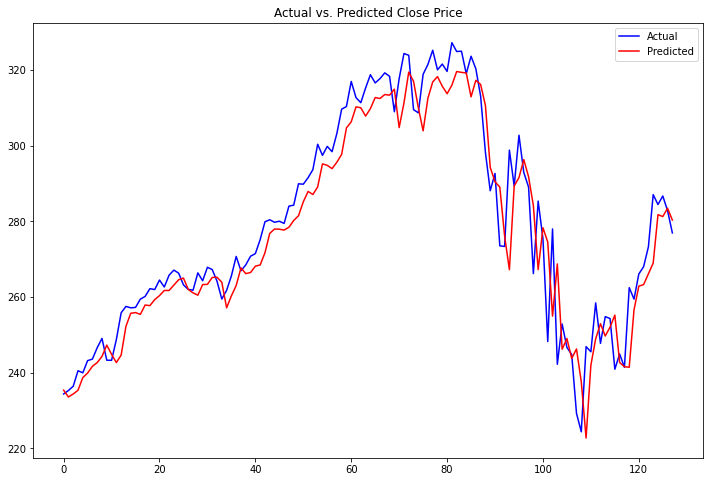

X_train shape: (2456, 1, 5)
X_test shape: (124, 1, 5)
y_train shape: (2456, 5)
y_test shape: (124, 5)
124/124 [==============================] - 0s 544us/step
MAE on test set: [9.71639045]


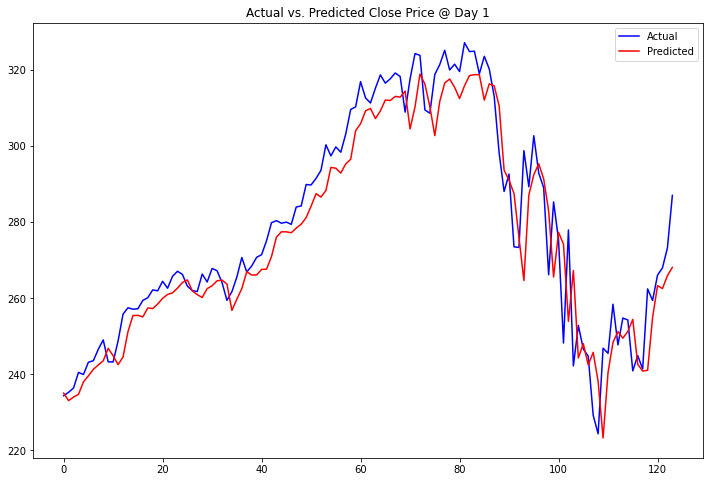

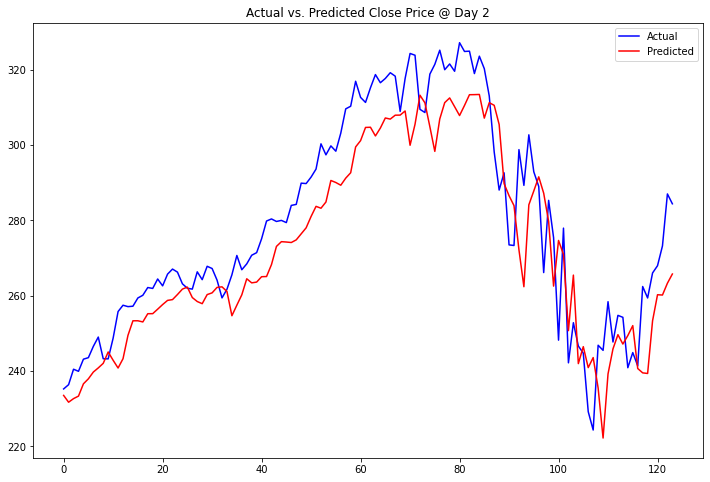

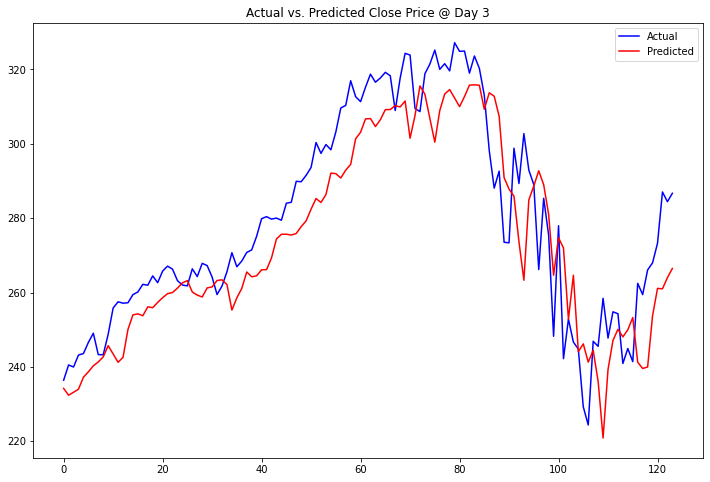

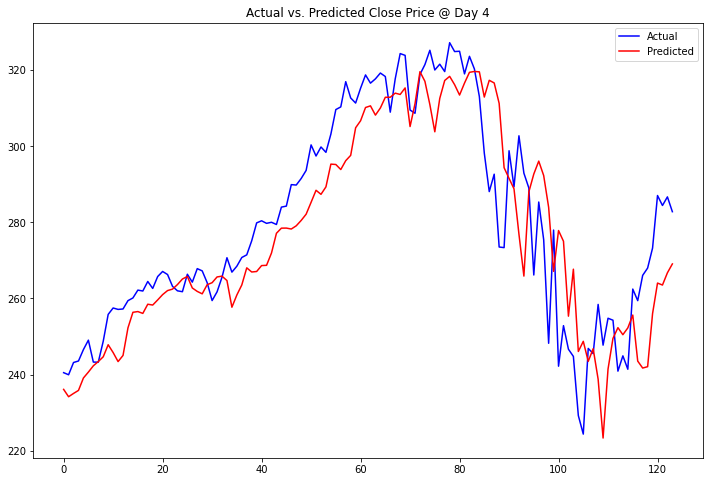

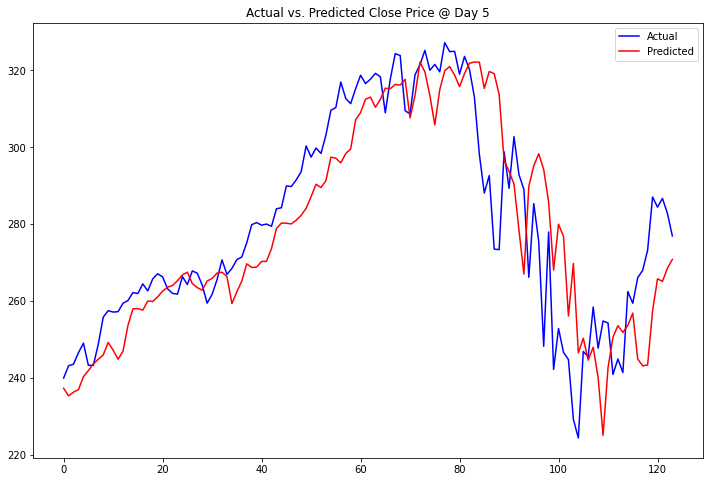

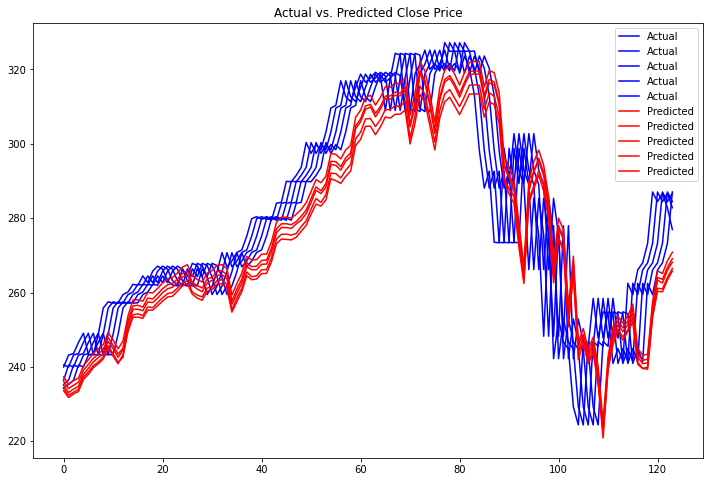

X_train shape: (2452, 5, 5)
X_test shape: (120, 5, 5)
y_train shape: (2452, 5)
y_test shape: (120, 5)
120/120 [==============================] - 0s 572us/step
MAE on test set: [16.9636339]


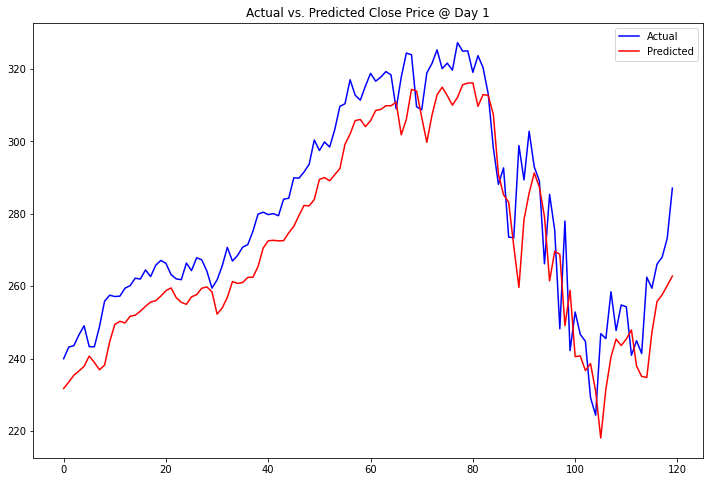

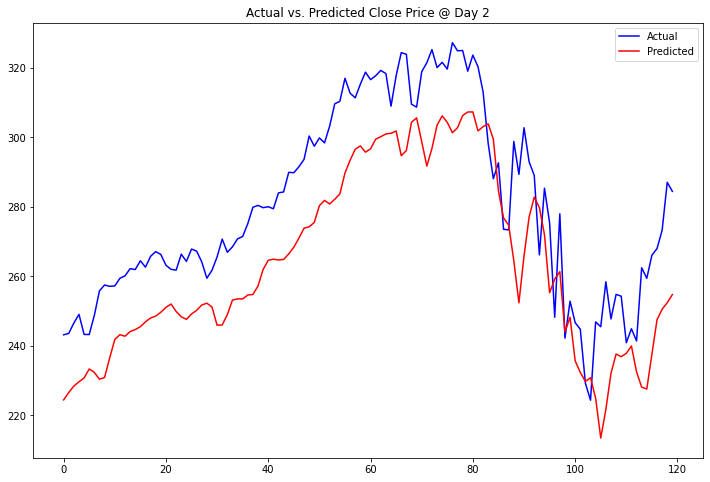

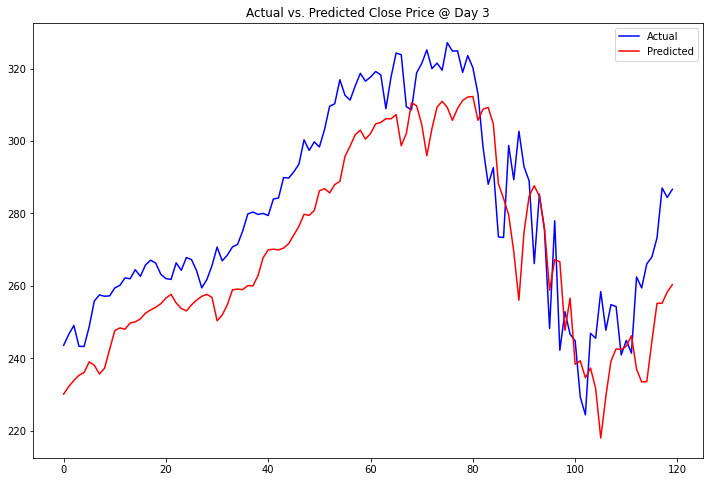

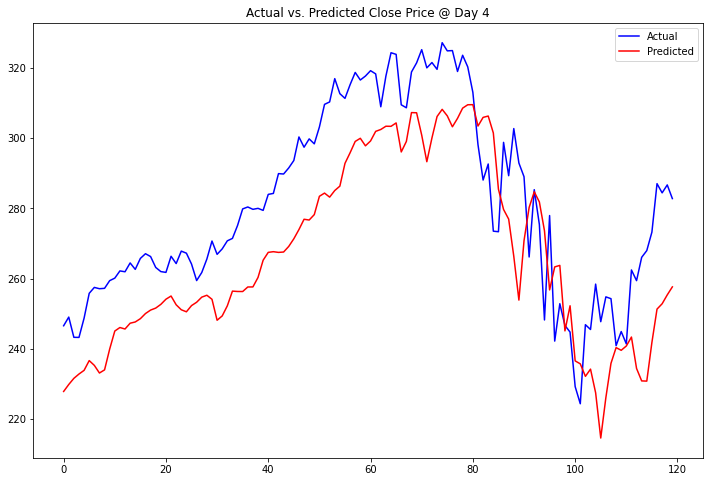

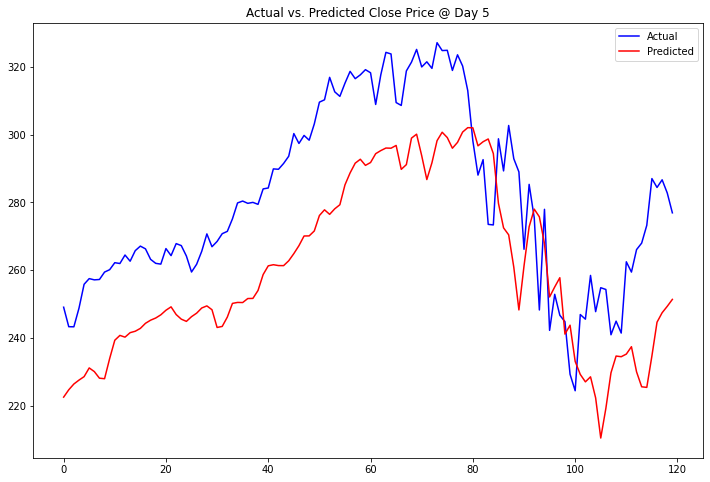

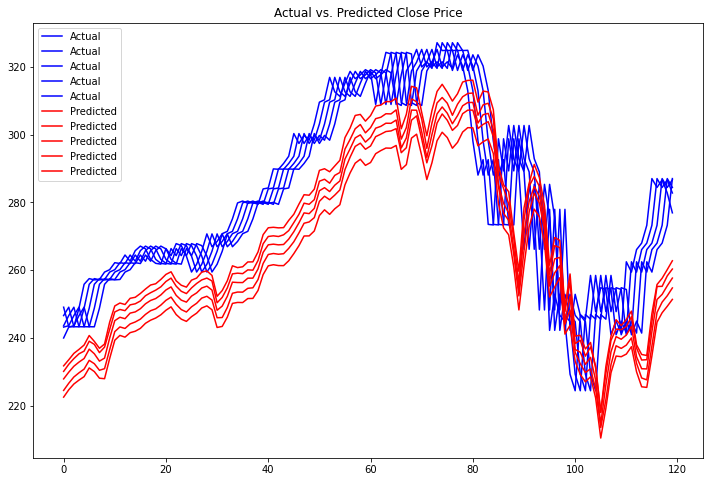

In [0]:
for i in [[4, 1], [1, 1], [1, 5], [5, 5]]:
  n_steps_in, n_steps_out = i[0], i[1]
  model = GRURegressor(n_steps_in=n_steps_in, n_steps_out=n_steps_out)

  # Load train and test datasets
  X_train, X_test, y_train, y_test = model.load_data()
  print('X_train shape:', X_train.shape)
  print('X_test shape:', X_test.shape)
  print('y_train shape:', y_train.shape)
  print('y_test shape:', y_test.shape)

  history = model.fit(X_train, y_train)

  # Evaluate MAE
  print('MAE on test set:', model.evaluate(X_test, y_test))

  # Make predictions
  y_preds = model.predict(X_test)

  # Plot actual vs. predicted
  model.plot(y_test, y_preds)

## References

B. Overland & J. Bennett. 2020. Supercharged Python. Boston, MA. Pearson Education, Inc

J. Brownlee. 2018. Deep Learning for Time Series Forecasting (1.4 ed.). 